In [2]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [3]:
pl.style.use('fabiostyle')
pl.rcParams['pdf.fonttype']=42
pl.rcParams['ps.fonttype']=42
# needs to find the library of functions
sys.path.append('../../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [4]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'decoding_vs_baseline_FIGURES'

In [5]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [6]:
# use `save_worspace(db)` to save variables at the end
pl.rcParams['pdf.fonttype']=42
pl.rcParams['ps.fonttype']=42

In [7]:
from itertools import product
def load_all_animals_vars(varname, animal_list, pilot_list=None, notebook='preprocessing'):
    all_of_them = {}
    for ani in animal_list:
        folder = '../%s/notebooks/autorestore/%s/' % (ani, notebook)
        all_of_them.update({ani: ut.load_variable(varname, folder)})
    return all_of_them

In [8]:
#mmc = multiple-comparisons correction (using bonferroni), where mcc = number of comparisons))

from matplotlib.lines import Line2D
def add_significance(ax, array1, array2, x1, x2, y, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001),mcc=1,suppress_ns=True):
    if sig_func is None:
        sig_func = lambda x, y: sstats.mannwhitneyu(x, y, alternative='two-sided')
    elif sig_func is 'ttest':
        sig_func = lambda x, y: sstats.ttest_ind(x,y)
    p = sig_func(array1, array2)[-1]
    sig_value = sig_func(array1, array2)[0]
    deltay = np.diff(ax.axis()[-2:])*ticksize
    if suppress_ns==True:
        if p <= thresholds[0]/mcc:
            line = Line2D([x1, x1, x2, x2], [y-deltay, y, y, y-deltay], lw=.5, color='k', clip_on=False)
            ax.add_line(line)
            ax.text(np.mean([x1, x2]), y,
                    '*' if p > thresholds[1]/mcc else
                    '**' if p > thresholds[2]/mcc else
                    '***',
                    ha='center', fontsize=5)
    else:
        line = Line2D([x1, x1, x2, x2], [y-deltay, y, y, y-deltay], lw=.5, color='k', clip_on=False)
        ax.add_line(line)
        ax.text(np.mean([x1, x2]), y+1,
            'n.s.' if p > thresholds[0]/mcc else
            '*' if p > thresholds[1]/mcc else
            '**' if p > thresholds[2]/mcc else
            '***',
            ha='center', fontsize=5)
    return sig_value, p

In [9]:
#mmc = multiple-comparisons correction (using bonferroni), where mcc = number of comparisons))

from matplotlib.lines import Line2D
def add_significance_point(ax, array1, array2, x1, y, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001),
                                   mcc=1,color='k',symbol='*'):
    if sig_func is None:
        sig_func = lambda x, y: sstats.mannwhitneyu(x, y, alternative='two-sided')
    elif sig_func is 'ttest':
        sig_func = lambda x, y: sstats.ttest_1samp(x,y)
    p = sig_func(array1, array2)[-1]
    sig_value = sig_func(array1, array2)[0]
    deltay = np.diff(ax.axis()[-2:])*ticksize
    #line = Line2D([x1, x1, x2, x2], [y-deltay, y, y, y-deltay], lw=.5, color='k', clip_on=False)
    #ax.add_line(line)
    ax.text(x1, y,
            "" if p > thresholds[0]/mcc else
            symbol if p > thresholds[1]/mcc else
            symbol+symbol if p > thresholds[2]/mcc else
            symbol+symbol+symbol,
            #symbol if p < thresholds[1]/mcc else
            #"",
            ha='center', fontsize=5,color=color)
    return sig_value, p

In [10]:
def report_stats (array1, array2, sig_func=None,mcc=1):
    if sig_func is None:
        sig_func = lambda x, y: sstats.mannwhitneyu(x, y, alternative='two-sided')
        U = sig_func(array1, array2)[0]
        z = ((U-((loops*loops)/2))/(np.sqrt(((loops*loops)*(loops+loops+1))/12)))
        r = z/np.sqrt(loops*2)
        p = sig_func(array1, array2)[-1]
        print "U =",U,"p =",p*mcc,"r =",r
    if sig_func is 'ttest':
        sig_func = lambda x, y: sstats.ttest_ind(x, y)
        cohens_d = (np.mean(array1)-np.mean(array2))/np.sqrt((np.std(array1)**2+np.std(array2)**2)/2)
        p = sig_func(array1, array2)[-1]
        print sig_func(array1, array2),"d =", cohens_d, 'corrected p =',p*mcc
    if sig_func is 'fishers':
        table = array1,array2
        sig_func = lambda x: sstats.fisher_exact(x, alternative='two-sided')
        p = sig_func(table)[-1]
        odds_ratio = sig_func(table)[0]
        print sig_func(table),"odd's ratio =", odds_ratio, 'corrected p =',p*mcc
        

def report_stats_chance (array1, chance=0.5, sig_func=None,mcc=1):
    if sig_func is None:
        sig_func = lambda x: sstats.wilcoxon(x)
        subtracted = [x-chance for x in array1]
        U = sig_func(subtracted)[0]
        z = ((U-((loops*loops)/2))/(np.sqrt(((loops*loops)*(loops+loops+1))/12)))
        r = z/np.sqrt(loops*2)
        print sig_func(subtracted),"r =",r
    elif sig_func is 'ttest':
        sig_func = lambda x, y: sstats.ttest_1samp(x,y)
        cohens_d = (np.mean(array1)-chance)/np.std(array1)
        print sig_func(array1,chance),"d =",cohens_d

In [11]:
def sig_vs_chance(ax, array1, chance, x1, y1, loops=10, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001),colors='k'):
    if sig_func is None:
        sig_func = lambda x: sstats.wilcoxon(x)
        subtracted = [x-chance for x in array1]
        p = sig_func(subtracted)[-1]
        sig_value = sig_func(subtracted)[0]
    elif sig_func is ttest:
        sig_func = lambda x, y: sstats.ttest_1samp(x,y)
        p = sig_func(array1,chance)[-1]
        sig_value = sig_func(array1,chance)[0]
    ax.text(x1, y1,
            'n.s.' if p>thresholds[0] else
            '*' if p>thresholds[1] else
            '**' if p>thresholds[2] else
            '***',
            ha='center', fontsize=4, color=colors)
    return sig_value, p

In [12]:
delta_t05s = 0.5
t_start05s = -5.5 
t_stop05s = 10.5

delta_t1s = 1
t_start1s = -5 
t_stop1s  = 11 

delta_t15s = 1
t_start15s = -5.5 
t_stop15s = 10.5  

delta_t2s = 2
t_start2s = -4
t_stop2s  = 10

In [13]:
sessions = 'expo','pre','post','post_hiatus'
bins = ['05s','1s','15s','2s']
bin_ranges=[]
for tb in bins:
    if tb == '05s':
        div=0.5
    elif tb=='15s':
        div=1.0
    else:
        div=tb[:-1]
            #print range(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div))))
    #for t in range(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div)))):
    bin_ranges.append(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div))))
print bin_ranges

[32, 16, 16, 7]


#bases = [4,1,1,0] #time bins for each tb delta to use for baseline (start at 3.5s, 4s, 4.5s, 4s)

In [14]:
#import results from notebooks
comparison_labels='CS1','CS2','CS3','CS4'
for tb,i in zip(bins,range(len(bins))):
    for t in range(bin_ranges[i]): # number of time bins
        for comp_la in comparison_labels:
            for reg in 'dhpc','vhpc':
                exec("baseline_scores_gmin_%s_%s_%s_%s = {}"%(tb,t,comp_la,reg))
                for sess in sessions:
                    exec("baseline_scores_gmin_%s_%s_%s_%s = ut.load_variable\
                          ('baseline_scores_gmin_%s_%s_%s','../notebooks/autorestore/decoding_vs_baseline_%s')"\
                          %(tb,t,comp_la,reg,tb,t,comp_la,reg))

In [15]:
loops=10
comparison_labels='CS1','CS2','CS3','CS4'
for tb,i in zip(bins,range(len(bins))):
    for t in range(bin_ranges[i]): # number of time bins
        for comp_la in comparison_labels:
            for reg in 'dhpc','vhpc':
                exec("ttest_tb_%s_%s_%s = {}"%(tb,t,comp_la))
                exec("mannwhitU_tb_%s_%s_%s = {}"%(tb,t,comp_la))
                for sess in sessions:
                    exec("ttest_tb_%s_%s_%s[sess] = sstats.ttest_ind(baseline_scores_gmin_%s_%s_%s_dhpc[sess][:loops],\
                       baseline_scores_gmin_%s_%s_%s_vhpc[sess][:loops])"%(tb,t,comp_la,tb,t,comp_la,tb,t,comp_la))
                    exec("mannwhitU_tb_%s_%s_%s[sess] = sstats.mannwhitneyu(baseline_scores_gmin_%s_%s_%s_dhpc[sess][:loops],\
                       baseline_scores_gmin_%s_%s_%s_vhpc[sess][:loops])"%(tb,t,comp_la,tb,t,comp_la,tb,t,comp_la))

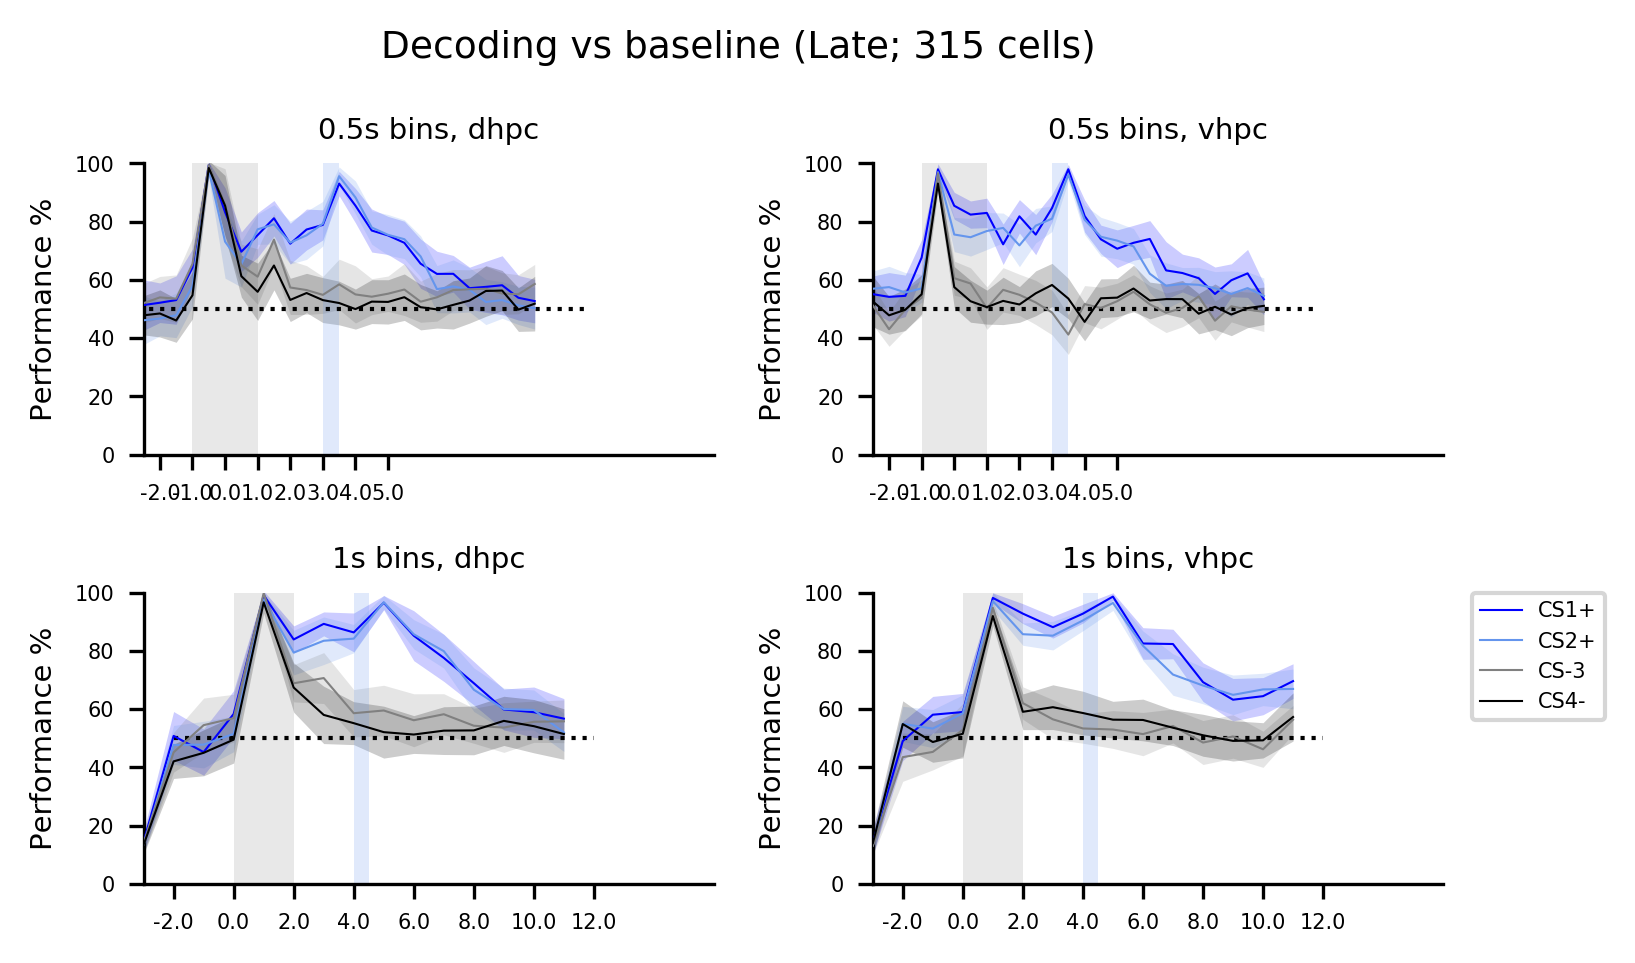

In [16]:
fig, ax = pl.subplots(2,2, figsize=(5,3))

for comp,c,la in zip(['CS1','CS2','CS3','CS4'],['b','cornflowerblue','grey','k'],
                     ['CS1+','CS2+','CS-3','CS4-']):
    for r,tb,sub in zip(range(2),bins[:2],[10,4]):
        for y, reg in zip([0,1],['dhpc','vhpc']):
            ax[r][y].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("baseline_scores_gmin_%s_%s_%s_%s['post']"%(tb,t,comp,reg)))*100) for t in range(bin_ranges[r])],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
            m = np.array([(np.mean(eval("baseline_scores_gmin_%s_%s_%s_%s['post']"%(tb,t,comp,reg)))*100) for t in range(bin_ranges[r])])
            s = np.array([np.std(eval("baseline_scores_gmin_%s_%s_%s_%s['post']"%(tb,t,comp,reg)))*100 for t in range(bin_ranges[r])])
            ax[r][y].fill_between([(t-sub) for t in range(bin_ranges[r])],m-s,m+s,alpha=0.2,color=c,linewidth=0)
for x,tick in zip(range(2),[2,1]):
    for y,reg in zip([0,1],['dhpc','vhpc']):
        ax[x][y].set_ylim(0, 100)
        ax[x][y].set_xlim(-3, bin_ranges[x])
        ax[x][y].set_xticks(np.arange(-2,13, 2.0))
        ax[x][y].set_xticklabels(np.arange(-2,13*tick, 2.0/tick))
        ax[x][y].hlines(50, -2*tick,bin_ranges[x]-4*tick, color='k', lw=1, linestyles='dotted')
        #ax[x][y].set_xlabel('Time from odor onset (s)')
        ax[x][y].set_ylabel('Performance %')
        pt.plot_period_bar(ax[x][y], 0, start_end=(0, 2*tick), color='k', delta_y=100,alpha=.09)
        pt.plot_period_bar(ax[x][y], 0, start_end=(4*tick, 4.5*tick), color='cornflowerblue', delta_y=100, alpha=.2)
        #ax[x][y].tick_params(
        #axis='x',          # changes apply to the x-axis
        #which='both',      # both major and minor ticks are affected
        #bottom=False,      # ticks along the bottom edge are off
        #top=False,         # ticks along the top edge are off
        #labelbottom=False) # labels along the bottom edge are off
        ax[0][y].set_title('0.5s bins, %s'%reg, color='k')
        ax[1][y].set_title('1s bins, %s'%reg, color = 'k')
        ax[1][1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs baseline (Late; 315 cells)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

#[y]fig.savefig('../figures/%s_run_gmin.jpg'%NOTEBOOK_NAME)

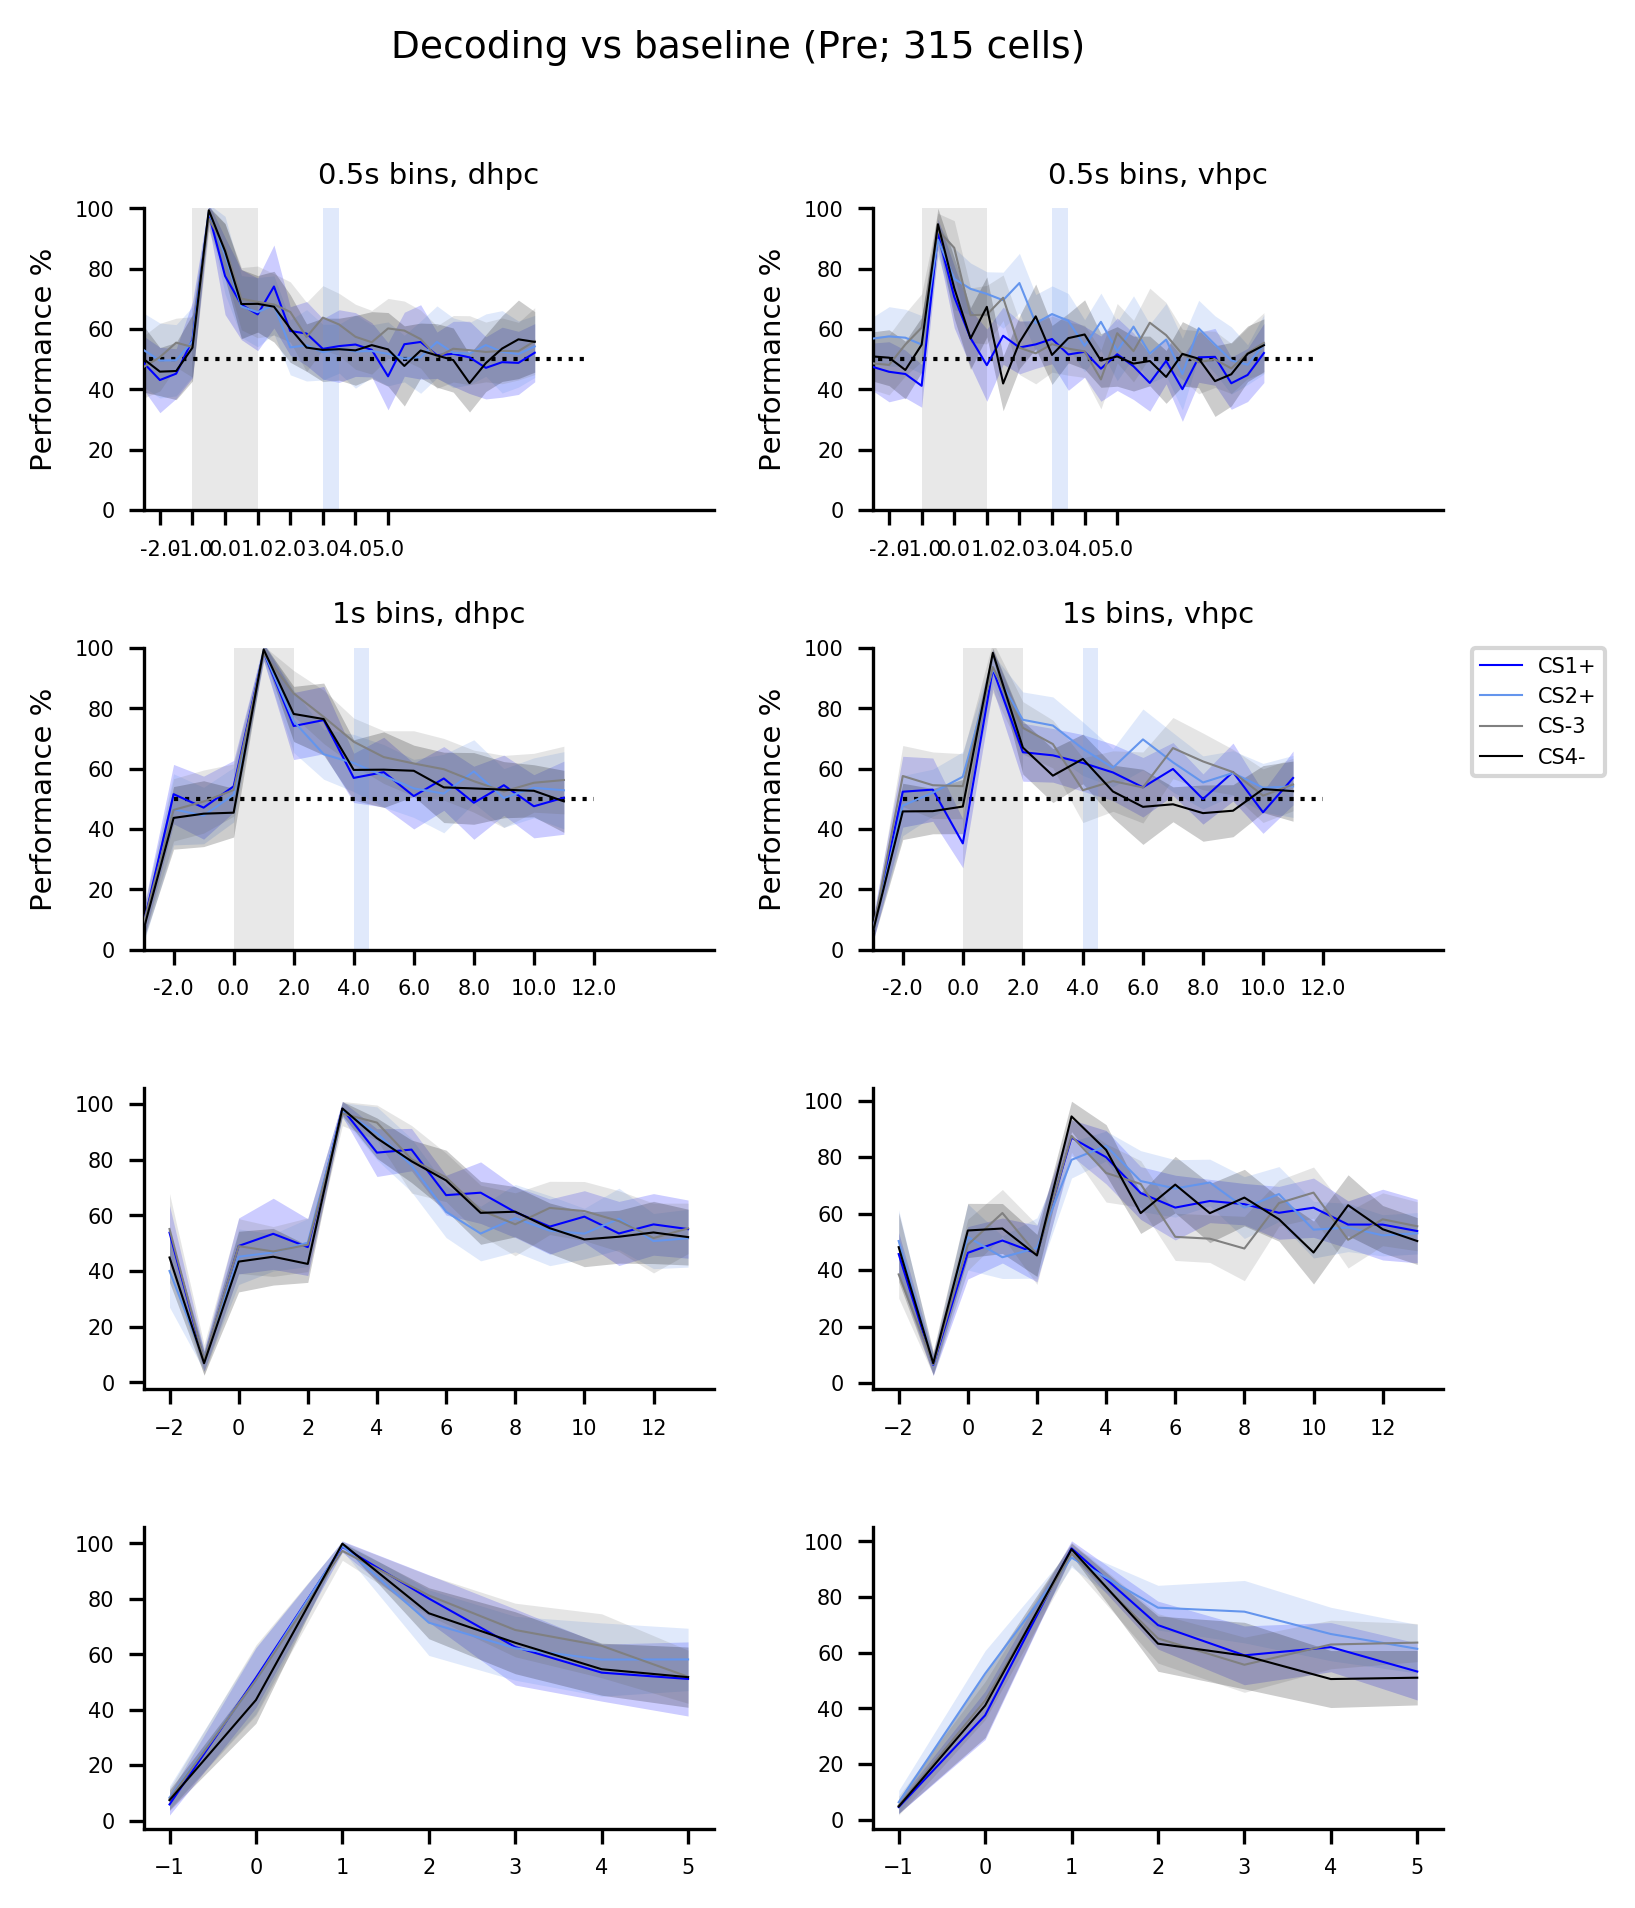

In [21]:
fig, ax = pl.subplots(4,2, figsize=(5,6))

for comp,c,la in zip(['CS1','CS2','CS3','CS4'],['b','cornflowerblue','grey','k'],
                     ['CS1+','CS2+','CS-3','CS4-']):
    for r,tb,sub in zip(range(4),bins,[10,4,2,1]):
        for y, reg in zip([0,1],['dhpc','vhpc']):
            ax[r][y].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("baseline_scores_gmin_%s_%s_%s_%s['expo']"%(tb,t,comp,reg)))*100) for t in range(bin_ranges[r])],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
            m = np.array([(np.mean(eval("baseline_scores_gmin_%s_%s_%s_%s['expo']"%(tb,t,comp,reg)))*100) for t in range(bin_ranges[r])])
            s = np.array([np.std(eval("baseline_scores_gmin_%s_%s_%s_%s['expo']"%(tb,t,comp,reg)))*100 for t in range(bin_ranges[r])])
            ax[r][y].fill_between([(t-sub) for t in range(bin_ranges[r])],m-s,m+s,alpha=0.2,color=c,linewidth=0)
for x,tick in zip(range(2),[2,1]):
    for y,reg in zip([0,1],['dhpc','vhpc']):
        ax[x][y].set_ylim(0, 100)
        ax[x][y].set_xlim(-3, bin_ranges[x])
        ax[x][y].set_xticks(np.arange(-2,13, 2.0))
        ax[x][y].set_xticklabels(np.arange(-2,13*tick, 2.0/tick))
        ax[x][y].hlines(50, -2*tick,bin_ranges[x]-4*tick, color='k', lw=1, linestyles='dotted')
        #ax[x][y].set_xlabel('Time from odor onset (s)')
        ax[x][y].set_ylabel('Performance %')
        pt.plot_period_bar(ax[x][y], 0, start_end=(0, 2*tick), color='k', delta_y=100,alpha=.09)
        pt.plot_period_bar(ax[x][y], 0, start_end=(4*tick, 4.5*tick), color='cornflowerblue', delta_y=100, alpha=.2)
        #ax[x][y].tick_params(
        #axis='x',          # changes apply to the x-axis
        #which='both',      # both major and minor ticks are affected
        #bottom=False,      # ticks along the bottom edge are off
        #top=False,         # ticks along the top edge are off
        #labelbottom=False) # labels along the bottom edge are off
        ax[0][y].set_title('0.5s bins, %s'%reg, color='k')
        ax[1][y].set_title('1s bins, %s'%reg, color = 'k')
        ax[1][1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs baseline (Pre; 315 cells)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

#[y]fig.savefig('../figures/%s_run_gmin.jpg'%NOTEBOOK_NAME)

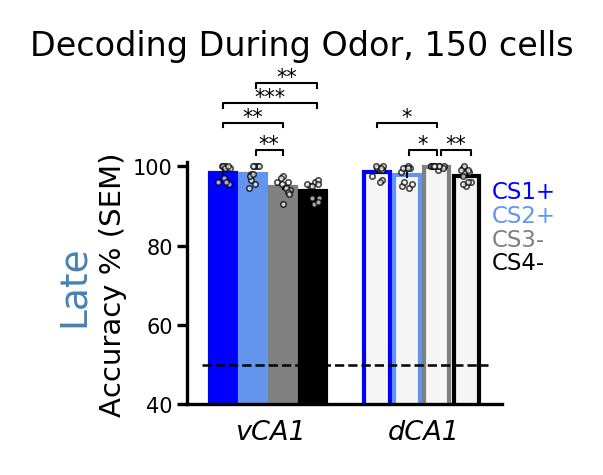

In [34]:
from matplotlib.patches import Patch
labels = ['vCA1','dCA1']
x = np.arange(len(labels))  # the label locations
width = 0.3# the width of the bars
loops=10
to_plot = [0,1]
t=5
tb='1s'
fig, ax = pl.subplots(figsize=(1.7,1.3))

for comp,c,la,wide in zip(['CS1','CS2','CS3','CS4'],['b','cornflowerblue','grey','k'],
                     ['CS1+','CS2+','CS-3','CS4-'],[-width/3-.25,0,width/3+.25,0.5+.2]):
    ste = np.array(np.std(eval("baseline_scores_gmin_%s_%s_%s_vhpc['post'][:loops]"%(tb,t,comp)))*100/np.sqrt(loops-1))
    ax.bar(wide, np.mean(eval("baseline_scores_gmin_%s_%s_%s_vhpc['post'][:loops]"%(tb,t,comp)))*100,
           width, edgecolor=c,color=c,yerr=ste)
    ax.scatter(wide+np.random.random(loops)*width/2-width/4.5, eval("baseline_scores_gmin_%s_%s_%s_vhpc['post'][:loops]"%(tb,t,comp))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
    
for comp,c,la,wide in zip(['CS1','CS2','CS3','CS4'],['b','cornflowerblue','grey','k'],
                     ['CS1+','CS2+','CS-3','CS4-'],[1.8+-width/3-.25,1.8+0,1.8+width/3+.25,1.8+0.5+.2]):
    ste = np.array(np.std(eval("baseline_scores_gmin_%s_%s_%s_dhpc['post'][:loops]"%(tb,t,comp)))*100/np.sqrt(loops-1))
    ax.bar(wide, np.mean(eval("baseline_scores_gmin_%s_%s_%s_dhpc['post'][:loops]"%(tb,t,comp)))*100,
           width, edgecolor=c,color='whitesmoke',yerr=ste)
    ax.scatter(wide+np.random.random(loops)*width/2-width/4.5, eval("baseline_scores_gmin_%s_%s_%s_dhpc['post'][:loops]"%(tb,t,comp))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')

ax.hlines(50,-.6,2.75, color='k', lw=.6, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy % (SEM)',labelpad=1.5)
#ax.set_title('Decoding During CS')
ax.set_ylim(40,101)
ax.set_xticks([0.2,2])
ax.set_xticklabels(labels,fontstyle='italic',fontsize=6.5)
#ax.legend([Patch(facecolor='darkorchid'),Patch(facecolor='sandybrown'),Patch(facecolor='darkturquoise')],
#          ['Rew','Shock','CS-'],loc=(.95,.6),frameon=False)
ax.text(2.8,92,'CS1+',color='b',fontsize=5.5)
ax.text(2.8,86,'CS2+',color='cornflowerblue',fontsize=5.5)
ax.text(2.8,80,'CS3-',color='grey',fontsize=5.5)
ax.text(2.8,74,'CS4-',color='k',fontsize=5.5)
ax.tick_params(axis='both',bottom=False,pad=1,length=2.5)
pvs=[]
test='ttest'
for reg,i in zip(['vhpc','dhpc'], [0,1.8]):
    pvs.append(add_significance(ax,eval("baseline_scores_gmin_%s_%s_CS1_%s['post'][:loops]"%(tb,t,reg)),
                                eval("baseline_scores_gmin_%s_%s_CS2_%s['post'][:loops]"%(tb,t,reg)),
                                -width/3-.25+i,i-.03,104,sig_func=test,mcc=3))
    pvs.append(add_significance(ax,eval("baseline_scores_gmin_%s_%s_CS2_%s['post'][:loops]"%(tb,t,reg)),
                                eval("baseline_scores_gmin_%s_%s_CS3_%s['post'][:loops]"%(tb,t,reg)),
        i+.03,width/3+.25+i,104,sig_func=test,mcc=3))
    pvs.append(add_significance(ax,eval("baseline_scores_gmin_%s_%s_CS4_%s['post'][:loops]"%(tb,t,reg)),
                                eval("baseline_scores_gmin_%s_%s_CS3_%s['post'][:loops]"%(tb,t,reg)),
        i+.4,.5+.25+i,104,sig_func=test,mcc=3))
    pvs.append(add_significance(ax,eval("baseline_scores_gmin_%s_%s_CS1_%s['post'][:loops]"%(tb,t,reg)),
                                eval("baseline_scores_gmin_%s_%s_CS3_%s['post'][:loops]"%(tb,t,reg)),
        -width/3-.25+i,width/3+.25+i,111,sig_func=test,mcc=3))
    pvs.append(add_significance(ax,eval("baseline_scores_gmin_%s_%s_CS1_%s['post'][:loops]"%(tb,t,reg)),
                                eval("baseline_scores_gmin_%s_%s_CS4_%s['post'][:loops]"%(tb,t,reg)),
        -width/3-.25+i,.5+.25+i,116,sig_func=test,mcc=3))
    pvs.append(add_significance(ax,eval("baseline_scores_gmin_%s_%s_CS2_%s['post'][:loops]"%(tb,t,reg)),
                                eval("baseline_scores_gmin_%s_%s_CS4_%s['post'][:loops]"%(tb,t,reg)),
        i+.03,.5+.25+i,121,sig_func=test,mcc=3))
    #print reg,'rw/sh',report_stats(eval("baseline_scores_tb_4_rw_%s['post'][-loops:]"%reg), eval("baseline_scores_tb_4_sh_%s['post'][-loops:]"%reg),mcc=3)
    #print reg,'rw/CS-',report_stats(eval("baseline_scores_tb_4_rw_%s['post'][-loops:]"%reg), eval("baseline_scores_tb_4_csm_%s['post'][-loops:]"%reg),mcc=3)
    #print reg,'sh/CS-',report_stats(eval("baseline_scores_tb_4_sh_%s['post'][-loops:]"%reg), eval("baseline_scores_tb_4_csm_%s['post'][-loops:]"%reg),mcc=3)

pl.suptitle('Decoding During Odor, 315 cells',y=1.2,fontsize=8)
ax.text(-2.1,70,'Late',rotation=90,fontsize=9,color='steelblue',ha='center',va='center')
fig.tight_layout(pad=2.5)

#fig.savefig('../figures/%s_bars_odor_RevLate.pdf'%NOTEBOOK_NAME)

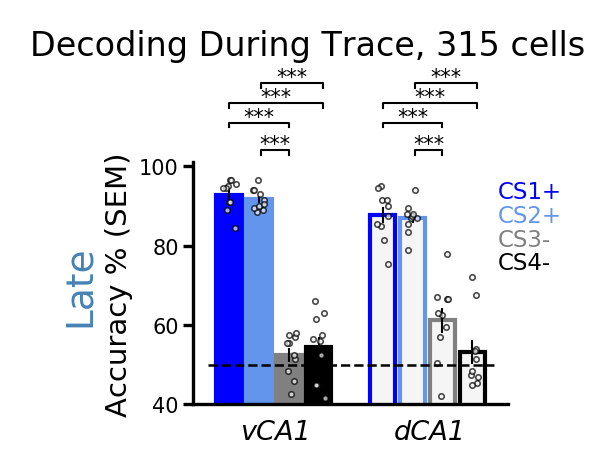

In [36]:
from matplotlib.patches import Patch
labels = ['vCA1','dCA1']
x = np.arange(len(labels))  # the label locations
width = 0.3# the width of the bars
loops=10
to_plot = [0,1]
t=8
tb='1s'
fig, ax = pl.subplots(figsize=(1.7,1.3))

for comp,c,la,wide in zip(['CS1','CS2','CS3','CS4'],['b','cornflowerblue','grey','k'],
                     ['CS1+','CS2+','CS-3','CS4-'],[-width/3-.25,0,width/3+.25,0.5+.2]):
    ste = np.array(np.std(eval("baseline_scores_gmin_%s_%s_%s_vhpc['post'][:loops]"%(tb,t,comp)))*100/np.sqrt(loops-1))
    ax.bar(wide, np.mean(eval("baseline_scores_gmin_%s_%s_%s_vhpc['post'][:loops]"%(tb,t,comp)))*100,
           width, edgecolor=c,color=c,yerr=ste)
    ax.scatter(wide+np.random.random(loops)*width/2-width/4.5, eval("baseline_scores_gmin_%s_%s_%s_vhpc['post'][:loops]"%(tb,t,comp))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
    
for comp,c,la,wide in zip(['CS1','CS2','CS3','CS4'],['b','cornflowerblue','grey','k'],
                     ['CS1+','CS2+','CS-3','CS4-'],[1.8+-width/3-.25,1.8+0,1.8+width/3+.25,1.8+0.5+.2]):
    ste = np.array(np.std(eval("baseline_scores_gmin_%s_%s_%s_dhpc['post'][:loops]"%(tb,t,comp)))*100/np.sqrt(loops-1))
    ax.bar(wide, np.mean(eval("baseline_scores_gmin_%s_%s_%s_dhpc['post'][:loops]"%(tb,t,comp)))*100,
           width, edgecolor=c,color='whitesmoke',yerr=ste)
    ax.scatter(wide+np.random.random(loops)*width/2-width/4.5, eval("baseline_scores_gmin_%s_%s_%s_dhpc['post'][:loops]"%(tb,t,comp))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')

ax.hlines(50,-.6,2.75, color='k', lw=.6, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy % (SEM)',labelpad=1.5)
#ax.set_title('Decoding During CS')
ax.set_ylim(40,101)
ax.set_xticks([0.2,2])
ax.set_xticklabels(labels,fontstyle='italic',fontsize=6.5)
#ax.legend([Patch(facecolor='darkorchid'),Patch(facecolor='sandybrown'),Patch(facecolor='darkturquoise')],
#          ['Rew','Shock','CS-'],loc=(.95,.6),frameon=False)
ax.text(2.8,92,'CS1+',color='b',fontsize=5.5)
ax.text(2.8,86,'CS2+',color='cornflowerblue',fontsize=5.5)
ax.text(2.8,80,'CS3-',color='grey',fontsize=5.5)
ax.text(2.8,74,'CS4-',color='k',fontsize=5.5)
ax.tick_params(axis='both',bottom=False,pad=1,length=2.5)
pvs=[]
test='ttest'
for reg,i in zip(['vhpc','dhpc'], [0,1.8]):
    pvs.append(add_significance(ax,eval("baseline_scores_gmin_%s_%s_CS1_%s['post'][:loops]"%(tb,t,reg)),
                                eval("baseline_scores_gmin_%s_%s_CS2_%s['post'][:loops]"%(tb,t,reg)),
                                -width/3-.25+i,i-.03,104,sig_func=test,mcc=3))
    pvs.append(add_significance(ax,eval("baseline_scores_gmin_%s_%s_CS2_%s['post'][:loops]"%(tb,t,reg)),
                                eval("baseline_scores_gmin_%s_%s_CS3_%s['post'][:loops]"%(tb,t,reg)),
        i+.03,width/3+.25+i,104,sig_func=test,mcc=3))
    pvs.append(add_significance(ax,eval("baseline_scores_gmin_%s_%s_CS4_%s['post'][:loops]"%(tb,t,reg)),
                                eval("baseline_scores_gmin_%s_%s_CS3_%s['post'][:loops]"%(tb,t,reg)),
        i+.4,.5+.25+i,104,sig_func=test,mcc=3))
    pvs.append(add_significance(ax,eval("baseline_scores_gmin_%s_%s_CS1_%s['post'][:loops]"%(tb,t,reg)),
                                eval("baseline_scores_gmin_%s_%s_CS3_%s['post'][:loops]"%(tb,t,reg)),
        -width/3-.25+i,width/3+.25+i,111,sig_func=test,mcc=3))
    pvs.append(add_significance(ax,eval("baseline_scores_gmin_%s_%s_CS1_%s['post'][:loops]"%(tb,t,reg)),
                                eval("baseline_scores_gmin_%s_%s_CS4_%s['post'][:loops]"%(tb,t,reg)),
        -width/3-.25+i,.5+.25+i,116,sig_func=test,mcc=3))
    pvs.append(add_significance(ax,eval("baseline_scores_gmin_%s_%s_CS2_%s['post'][:loops]"%(tb,t,reg)),
                                eval("baseline_scores_gmin_%s_%s_CS4_%s['post'][:loops]"%(tb,t,reg)),
        i+.03,.5+.25+i,121,sig_func=test,mcc=3))
    #print reg,'rw/sh',report_stats(eval("baseline_scores_tb_4_rw_%s['post'][-loops:]"%reg), eval("baseline_scores_tb_4_sh_%s['post'][-loops:]"%reg),mcc=3)
    #print reg,'rw/CS-',report_stats(eval("baseline_scores_tb_4_rw_%s['post'][-loops:]"%reg), eval("baseline_scores_tb_4_csm_%s['post'][-loops:]"%reg),mcc=3)
    #print reg,'sh/CS-',report_stats(eval("baseline_scores_tb_4_sh_%s['post'][-loops:]"%reg), eval("baseline_scores_tb_4_csm_%s['post'][-loops:]"%reg),mcc=3)

pl.suptitle('Decoding During Trace, 315 cells',y=1.2,fontsize=8)
ax.text(-2.1,70,'Late',rotation=90,fontsize=9,color='steelblue',ha='center',va='center')
fig.tight_layout(pad=2.5)

#fig.savefig('../figures/%s_bars_odor_RevLate.pdf'%NOTEBOOK_NAME)

# left off here

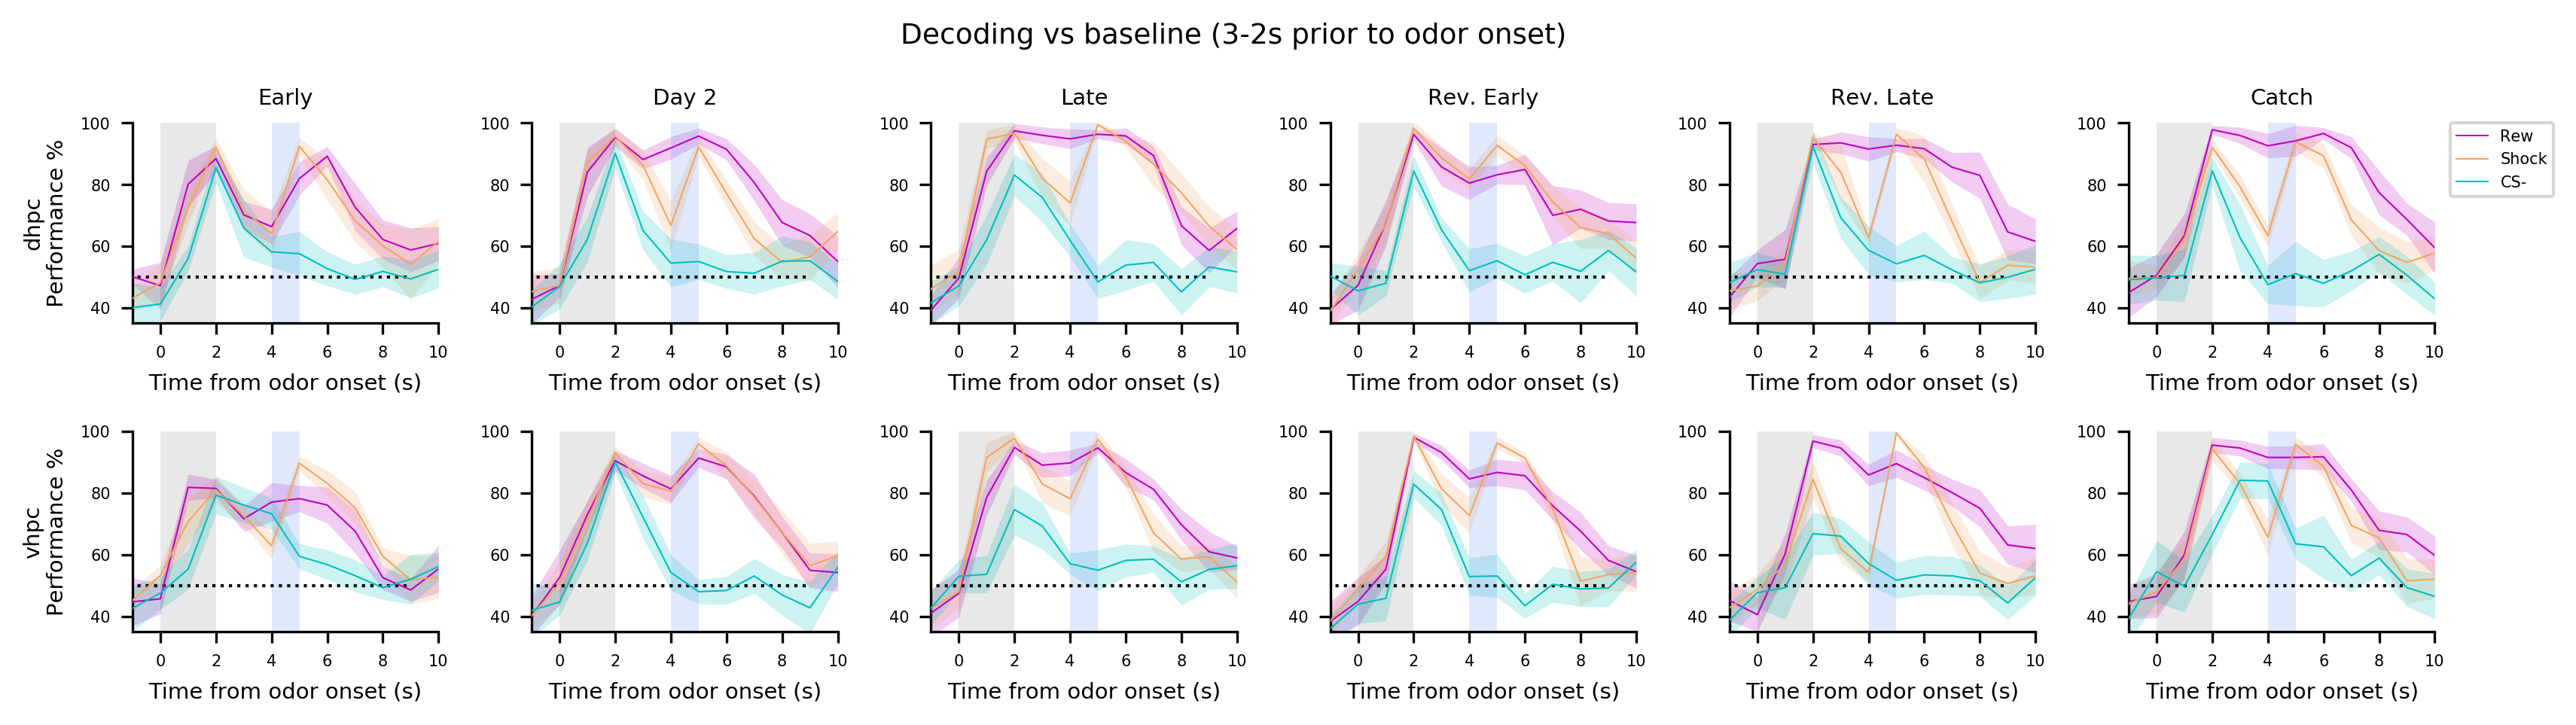

In [20]:
fig, ax = pl.subplots(2,6, figsize=(11, 3))

loops=10
for comp,c,la in zip(['rw','sh','csm'],['m','sandybrown','c'],['Rew','Shock','CS-']):
    for y,sess in zip(range(len(sessions)),sessions):
        for x,reg in zip (range(2),['dhpc','vhpc']):
            ax[x][y].plot([(t-2) for t in range(13)], [(np.mean(eval("baseline_scores_tb_%s_%s_%s[sess][-loops:]"%(t,comp,reg)))*100) for t in range(13)],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
            m = np.array([(np.mean(eval("baseline_scores_tb_%s_%s_%s[sess][-loops:]"%(t,comp,reg)))*100) for t in range(13)])
            s = np.array([np.std(eval("baseline_scores_tb_%s_%s_%s[sess][-loops:]"%(t,comp,reg)))*100 for t in range(13)])
            ax[x][y].fill_between([(t-2) for t in range(13)],m-s,m+s,alpha=0.2,color=c,linewidth=0)

for x,reg in zip (range(2),['dhpc','vhpc']):
    for y in range (6):
        ax[x][y].set_ylim(35, 100)
        ax[x][y].set_xlim(-1, 9)
        ax[x][y].set_xticks(np.arange(0,11, 2))
        ax[x][y].set_xticklabels(np.arange(0,11, 2))
        ax[x][y].hlines(50, -5,9, color='k', lw=1, linestyles='dotted')
        ax[x][y].set_xlabel('Time from odor onset (s)')
        ax[x][0].set_ylabel(reg+'\nPerformance %')
        pt.plot_period_bar(ax[x][y], 0, start_end=(0, 2), color='k', delta_y=100,alpha=.09)
        pt.plot_period_bar(ax[x][y], 0, start_end=(4, 5), color='cornflowerblue', delta_y=100, alpha=.2)
ax[0][0].set_title('Early')
ax[0][1].set_title('Day 2')
ax[0][2].set_title('Late')
ax[0][3].set_title('Rev. Early')
ax[0][4].set_title('Rev. Late')
ax[0][5].set_title('Catch')
ax[0][5].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs baseline (3-2s prior to odor onset)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

fig.savefig('../figures/%s_dv.pdf'%NOTEBOOK_NAME)

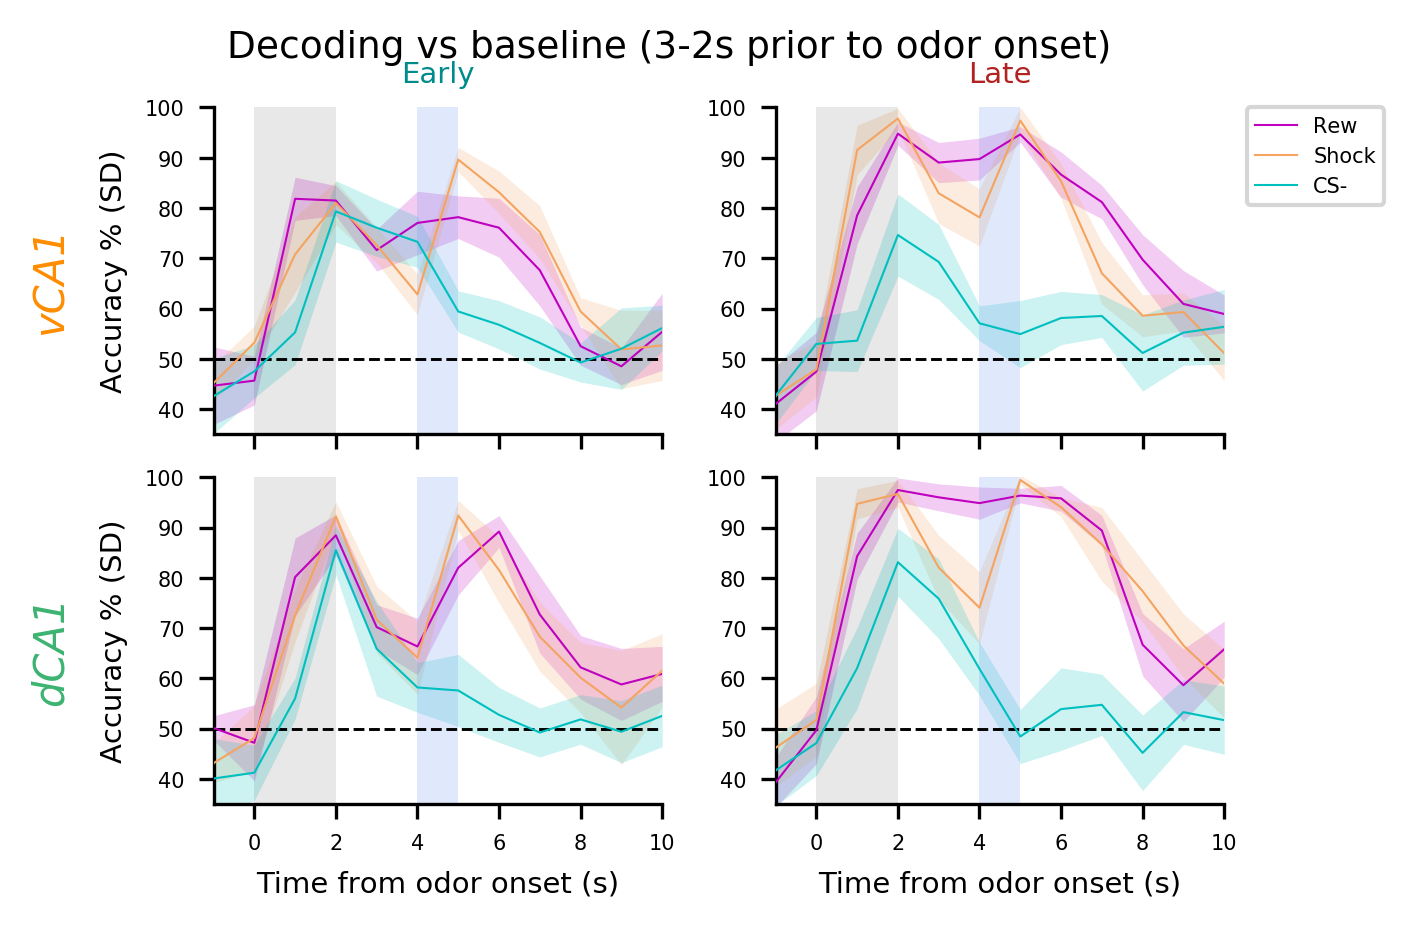

In [107]:
fig, ax = pl.subplots(2,2, figsize=(4, 3),sharex=True)

loops=10
for comp,c,la in zip(['rw','sh','csm'],['m','sandybrown','c'],['Rew','Shock','CS-']):
    for y,sess in zip(range(2),['pre','post']):
        for x,reg in zip (range(2),['vhpc','dhpc']):
            ax[x][y].plot([(t-2) for t in range(13)], [(np.mean(eval("baseline_scores_tb_%s_%s_%s[sess][-loops:]"%(t,comp,reg)))*100) for t in range(13)],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
            m = np.array([(np.mean(eval("baseline_scores_tb_%s_%s_%s[sess][-loops:]"%(t,comp,reg)))*100) for t in range(13)])
            s = np.array([np.std(eval("baseline_scores_tb_%s_%s_%s[sess][-loops:]"%(t,comp,reg)))*100 for t in range(13)])
            ax[x][y].fill_between([(t-2) for t in range(13)],m-s,m+s,alpha=0.2,color=c,linewidth=0)

for x,reg in zip (range(2),['vhpc','dhpc']):
    for y in range (2):
        ax[x][y].set_ylim(35, 100)
        ax[x][y].set_xlim(-1, 10)
        ax[x][y].set_xticks(np.arange(0,11, 2))
        ax[x][y].set_xticklabels(np.arange(0,11, 2))
        ax[x][y].hlines(50, -1,10, color='k', lw=.7, linestyles='dashed')
        ax[1][y].set_xlabel('Time from odor onset (s)')
        ax[x][0].set_ylabel('Accuracy % (SD)')
        pt.plot_period_bar(ax[x][y], 0, start_end=(0, 2), color='k', delta_y=100,alpha=.09)
        pt.plot_period_bar(ax[x][y], 0, start_end=(4, 5), color='cornflowerblue', delta_y=100, alpha=.2)
ax[0][0].set_title('Early',color='darkcyan')
ax[0][1].set_title('Late',color='firebrick')
ax[0][0].text(-5.5,70,'vCA1',rotation=90,color='darkorange',fontsize=10,fontstyle='italic')
ax[1][0].text(-5.5,70,'dCA1',rotation=90,color='mediumseagreen',fontsize=10,fontstyle='italic')
ax[0][1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs baseline (3-2s prior to odor onset)", fontsize=9, y=1.)

fig.tight_layout(pad=1.5)

fig.savefig('../figures/%s_dv_PrPo.pdf'%NOTEBOOK_NAME)

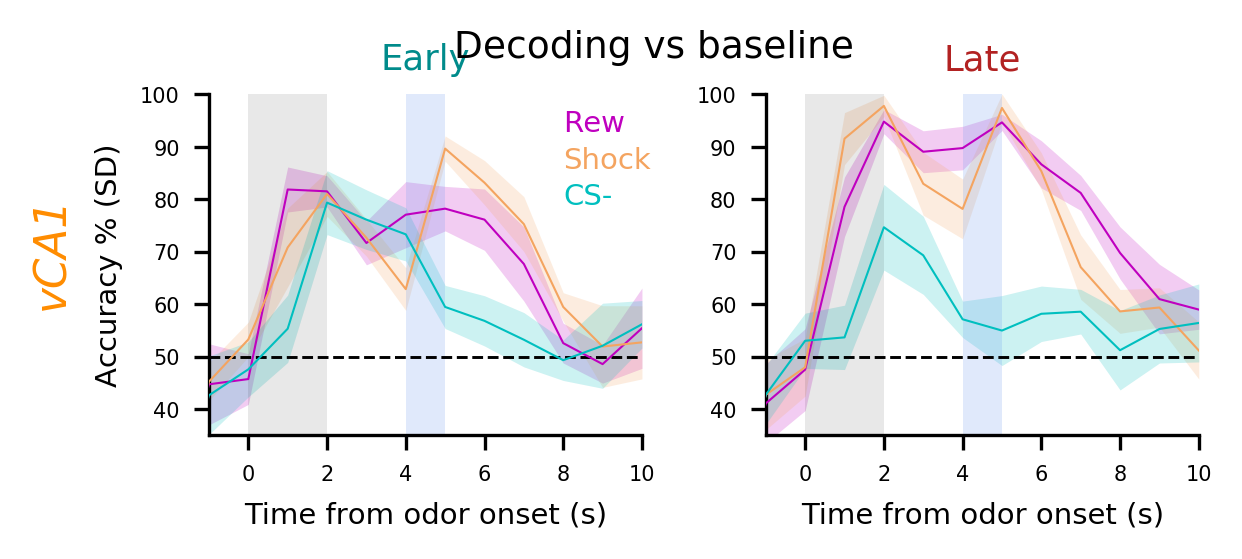

In [19]:
fig, ax = pl.subplots(1,2, figsize=(4,1.9),sharex=True)

loops=10
for comp,c,la in zip(['rw','sh','csm'],['m','sandybrown','c'],['Rew','Shock','CS-']):
    for y,sess in zip(range(2),['pre','post']):
            ax[y].plot([(t-2) for t in range(13)], [(np.mean(eval("baseline_scores_tb_%s_%s_vhpc[sess][-loops:]"%(t,comp)))*100) for t in range(13)],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
            m = np.array([(np.mean(eval("baseline_scores_tb_%s_%s_vhpc[sess][-loops:]"%(t,comp)))*100) for t in range(13)])
            s = np.array([np.std(eval("baseline_scores_tb_%s_%s_vhpc[sess][-loops:]"%(t,comp)))*100 for t in range(13)])
            ax[y].fill_between([(t-2) for t in range(13)],m-s,m+s,alpha=0.2,color=c,linewidth=0)

for y in range (2):
        ax[y].set_ylim(35, 100)
        ax[y].set_xlim(-1, 10)
        ax[y].set_xticks(np.arange(0,11, 2))
        ax[y].set_xticklabels(np.arange(0,11, 2))
        ax[y].hlines(50, -1,10, color='k', lw=.7, linestyles='dashed')
        ax[y].set_xlabel('Time from odor onset (s)')
        ax[0].set_ylabel('Accuracy % (SD)')
        pt.plot_period_bar(ax[y], 0, start_end=(0, 2), color='k', delta_y=100,alpha=.09)
        pt.plot_period_bar(ax[y], 0, start_end=(4, 5), color='cornflowerblue', delta_y=100, alpha=.2)
ax[0].set_title('Early',color='darkcyan',fontsize=8.5)
ax[1].set_title('Late',color='firebrick',fontsize=8.5)
#ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax[0].text(-5,70,'vCA1',color='darkorange',fontstyle='italic',fontsize=10.5,rotation=90,ha='center',va='center')
ax[0].text(8,93,'Rew',color='m',fontsize=7)
ax[0].text(8,86,'Shock',color='sandybrown',fontsize=7)
ax[0].text(8,79,'CS-',color='c',fontsize=7)
pl.suptitle("Decoding vs baseline", fontsize=9, y=.95)

fig.tight_layout(pad=2)

fig.savefig('../figures/%s_v_PrPo.pdf'%NOTEBOOK_NAME)

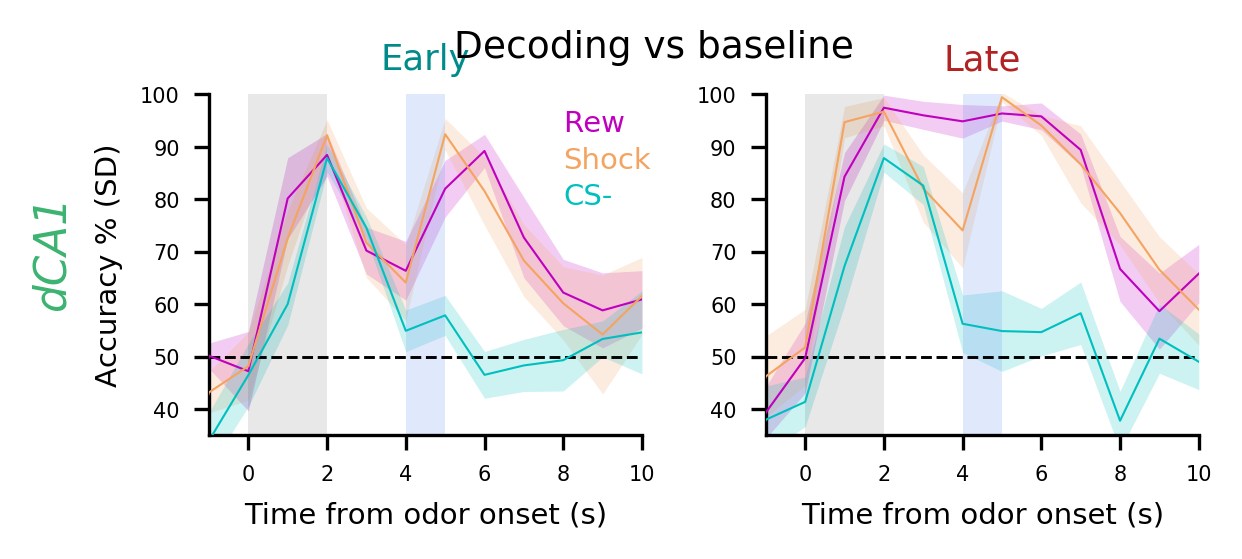

In [20]:
fig, ax = pl.subplots(1,2, figsize=(4, 1.9),sharex=True)

loops=10
for comp,c,la in zip(['rw','sh','csm'],['m','sandybrown','c'],['Rew','Shock','CS-']):
    for y,sess in zip(range(2),['pre','post']):
            ax[y].plot([(t-2) for t in range(13)], [(np.mean(eval("baseline_scores_tb_%s_%s_dhpc[sess][-loops:]"%(t,comp)))*100) for t in range(13)],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
            m = np.array([(np.mean(eval("baseline_scores_tb_%s_%s_dhpc[sess][-loops:]"%(t,comp)))*100) for t in range(13)])
            s = np.array([np.std(eval("baseline_scores_tb_%s_%s_dhpc[sess][-loops:]"%(t,comp)))*100 for t in range(13)])
            ax[y].fill_between([(t-2) for t in range(13)],m-s,m+s,alpha=0.2,color=c,linewidth=0)

for y in range (2):
        ax[y].set_ylim(35, 100)
        ax[y].set_xlim(-1, 10)
        ax[y].set_xticks(np.arange(0,11, 2))
        ax[y].set_xticklabels(np.arange(0,11, 2))
        ax[y].hlines(50, -1,10, color='k', lw=.7, linestyles='dashed')
        ax[y].set_xlabel('Time from odor onset (s)')
        ax[0].set_ylabel('Accuracy % (SD)')
        pt.plot_period_bar(ax[y], 0, start_end=(0, 2), color='k', delta_y=100,alpha=.09)
        pt.plot_period_bar(ax[y], 0, start_end=(4, 5), color='cornflowerblue', delta_y=100, alpha=.2)
ax[0].set_title('Early',color='darkcyan',fontsize=8.5)
ax[1].set_title('Late',color='firebrick',fontsize=8.5)
#ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax[0].text(-5,70,'dCA1',color='mediumseagreen',fontstyle='italic',fontsize=10.5,rotation=90,ha='center',va='center')
ax[0].text(8,93,'Rew',color='m',fontsize=7)
ax[0].text(8,86,'Shock',color='sandybrown',fontsize=7)
ax[0].text(8,79,'CS-',color='c',fontsize=7)
pl.suptitle("Decoding vs baseline", fontsize=9, y=.95)

fig.tight_layout(pad=2)

fig.savefig('../figures/%s_d_PrPo.pdf'%NOTEBOOK_NAME)

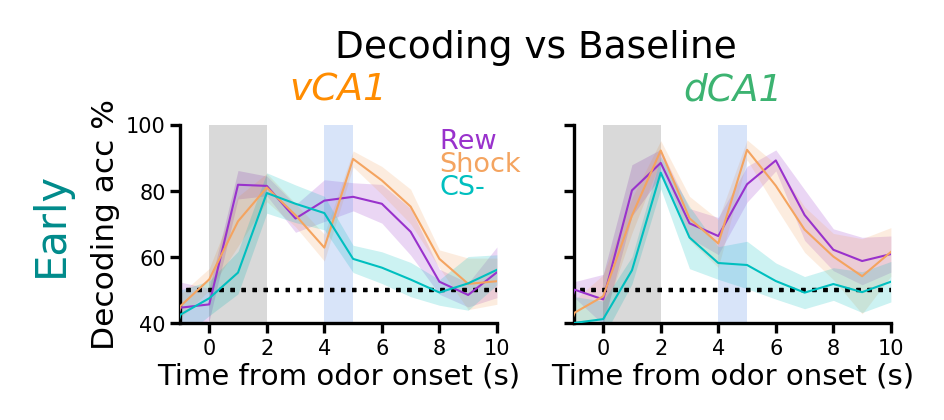

In [175]:
fig, ax = pl.subplots(1,2, figsize=(2.9, 1.2),sharey=True)

loops=10
for comp,c,la in zip(['rw','sh','csm'],['darkorchid','sandybrown','c'],['Rew','Shock','CS-']):
    for y,reg in zip(range(2),['vhpc','dhpc']):
        ax[y].plot([(t-2) for t in range(13)], [(np.mean(eval("baseline_scores_tb_%s_%s_%s['pre'][-loops:]"%(t,comp,reg)))*100) for t in range(13)],
                   color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
        m = np.array([(np.mean(eval("baseline_scores_tb_%s_%s_%s['pre'][-loops:]"%(t,comp,reg)))*100) for t in range(13)])
        s = np.array([np.std(eval("baseline_scores_tb_%s_%s_%s['pre'][-loops:]"%(t,comp,reg)))*100 for t in range(13)])
        ax[y].fill_between([(t-2) for t in range(13)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
        ax[y].set_ylim(40, 100)
        ax[y].set_xlim(-1,10)
        ax[y].tick_params(axis='both',pad=1,length=2.5)
        ax[y].set_xticks(np.arange(0,11, 2))
        ax[y].set_xticklabels(np.arange(0,11, 2))
        ax[y].hlines(50, -5,11, color='k', lw=1, linestyles='dotted')
        ax[y].set_xlabel('Time from odor onset (s)',labelpad=1)
        ax[0].set_ylabel('Decoding acc %',fontsize=7.5,labelpad=1.5)
        pt.plot_period_bar(ax[y], 0, start_end=(0, 2), color='k', delta_y=100,alpha=.05)
        pt.plot_period_bar(ax[y], 0, start_end=(4, 5), color='cornflowerblue', delta_y=100, alpha=.09)
ax[0].text(-5.5,70,'Early',color='darkcyan',rotation=90,ha='center',va='center',fontsize=10)
ax[0].text(8,93,'Rew',color='darkorchid',fontsize=6.5)
ax[0].text(8,86,'Shock',color='sandybrown',fontsize=6.5)
ax[0].text(8,79,'CS-',color='c',fontsize=6.5)
ax[0].set_title('vCA1', color ='darkorange',fontsize=9,fontstyle='italic')
ax[1].set_title('dCA1', color ='mediumseagreen',fontsize=9,fontstyle='italic')
#ax[0].legend(bbox_to_anchor=(.7, .99), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs Baseline", fontsize=9, y=1.06,x=.535)

fig.tight_layout(pad=1)
fig.savefig('../figures/%s_dv_Early.pdf'%NOTEBOOK_NAME)

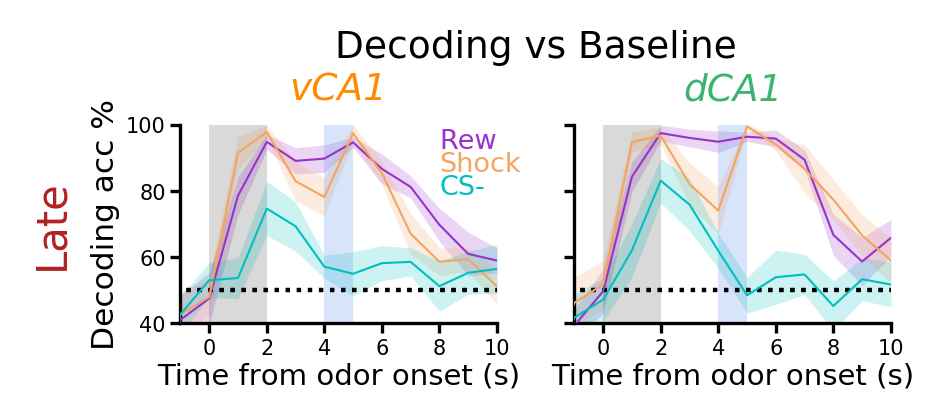

In [170]:
fig, ax = pl.subplots(1,2, figsize=(2.9, 1.2),sharey=True)

loops=10
for comp,c,la in zip(['rw','sh','csm'],['darkorchid','sandybrown','c'],['Rew','Shock','CS-']):
    for y,reg in zip(range(2),['vhpc','dhpc']):
        ax[y].plot([(t-2) for t in range(13)], [(np.mean(eval("baseline_scores_tb_%s_%s_%s['post'][-loops:]"%(t,comp,reg)))*100) for t in range(13)],
                   color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
        m = np.array([(np.mean(eval("baseline_scores_tb_%s_%s_%s['post'][-loops:]"%(t,comp,reg)))*100) for t in range(13)])
        s = np.array([np.std(eval("baseline_scores_tb_%s_%s_%s['post'][-loops:]"%(t,comp,reg)))*100 for t in range(13)])
        ax[y].fill_between([(t-2) for t in range(13)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
        ax[y].set_ylim(40, 100)
        ax[y].set_xlim(-1,10)
        ax[y].tick_params(axis='both',pad=1,length=2.5)
        ax[y].set_xticks(np.arange(0,11, 2))
        ax[y].set_xticklabels(np.arange(0,11, 2))
        ax[y].hlines(50, -5,11, color='k', lw=1, linestyles='dotted')
        ax[y].set_xlabel('Time from odor onset (s)',labelpad=1)
        ax[0].set_ylabel('Decoding acc %',fontsize=7.5,labelpad=1.5)
        pt.plot_period_bar(ax[y], 0, start_end=(0, 2), color='k', delta_y=100,alpha=.05)
        pt.plot_period_bar(ax[y], 0, start_end=(4, 5), color='cornflowerblue', delta_y=100, alpha=.09)
ax[0].text(-5.5,70,'Late',color='Firebrick',rotation=90,ha='center',va='center',fontsize=10)
ax[0].text(8,93,'Rew',color='darkorchid',fontsize=6.5)
ax[0].text(8,86,'Shock',color='sandybrown',fontsize=6.5)
ax[0].text(8,79,'CS-',color='c',fontsize=6.5)
ax[0].set_title('vCA1', color ='darkorange',fontsize=9,fontstyle='italic')
ax[1].set_title('dCA1', color ='mediumseagreen',fontsize=9,fontstyle='italic')
#ax[0].legend(bbox_to_anchor=(.7, .99), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs Baseline", fontsize=9, y=1.06,x=.535)

fig.tight_layout(pad=1)
fig.savefig('../figures/%s_dv_Late.pdf'%NOTEBOOK_NAME)

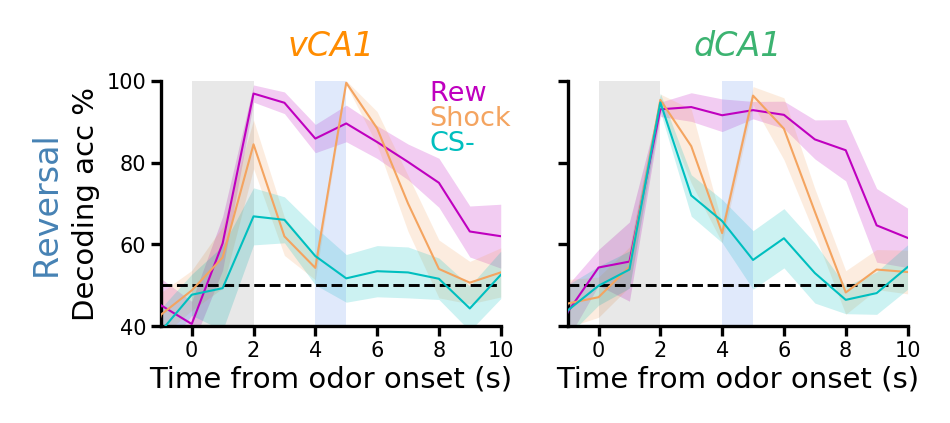

In [70]:
fig, ax = pl.subplots(1,2, figsize=(3., 1.35),sharey=True)

loops=10
for comp,c,la in zip(['rw','sh','csm'],['m','sandybrown','c'],['Rew','Shock','CS-']):
    for y,reg in zip(range(2),['vhpc','dhpc']):
            ax[y].plot([(t-2) for t in range(13)], [(np.mean(eval("baseline_scores_tb_%s_%s_%s['post_rev'][-loops:]"%(t,comp,reg)))*100) for t in range(13)],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
            m = np.array([(np.mean(eval("baseline_scores_tb_%s_%s_%s['post_rev'][-loops:]"%(t,comp,reg)))*100) for t in range(13)])
            s = np.array([np.std(eval("baseline_scores_tb_%s_%s_%s['post_rev'][-loops:]"%(t,comp,reg)))*100 for t in range(13)])
            ax[y].fill_between([(t-2) for t in range(13)],m-s,m+s,alpha=0.2,color=c,linewidth=0)

for y in range (2):
        ax[y].set_ylim(40, 100)
        ax[y].tick_params(axis='both',pad=1,length=2.5)
        ax[y].set_xlim(-1, 10)
        ax[y].set_xticks(np.arange(0,11, 2))
        ax[y].set_xticklabels(np.arange(0,11, 2))
        ax[y].hlines(50, -1,10, color='k', lw=.7, linestyles='dashed')
        ax[y].set_xlabel('Time from odor onset (s)',labelpad=1)
        ax[0].set_ylabel('Decoding acc %',labelpad=1.5)
        pt.plot_period_bar(ax[y], 0, start_end=(0, 2), color='k', delta_y=100,alpha=.09)
        pt.plot_period_bar(ax[y], 0, start_end=(4, 5), color='cornflowerblue', delta_y=100, alpha=.2)
ax[0].set_title('vCA1',color='darkorange',fontsize=8,fontstyle='italic')
ax[1].set_title('dCA1',color='mediumseagreen',fontsize=8,fontstyle='italic')
#ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax[0].text(-4.7,70,'Reversal',color='steelblue',rotation=90,ha='center',va='center',fontsize=8)
ax[0].text(7.7,95,'Rew',color='m',fontsize=6.5)
ax[0].text(7.7,89,'Shock',color='sandybrown',fontsize=6.5)
ax[0].text(7.7,83,'CS-',color='c',fontsize=6.5)
#pl.suptitle("Decoding vs baseline", fontsize=9, y=1.02)

fig.tight_layout(pad=1)

fig.savefig('../figures/%s_dv_RevLate.pdf'%NOTEBOOK_NAME)

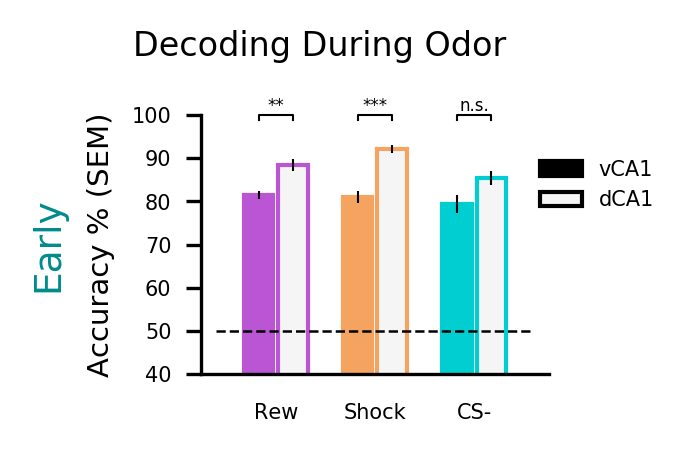

In [108]:
from matplotlib.patches import Patch
labels = ['Rew','Shock','CS-']
x = np.arange(len(labels))  # the label locations
width = 0.3# the width of the bars
loops=10
r={}
s={}
p={}
#to_plot = [0,1]
fig, ax = pl.subplots(figsize=(1.9,1.4))

            
r[sess] = np.array(np.std(baseline_scores_tb_4_rw_vhpc['pre'][-loops:])*100/np.sqrt(loops-1))
ax.bar(-width/2-.025, np.mean(baseline_scores_tb_4_rw_vhpc['pre'][-loops:])*100, width, edgecolor='mediumorchid',color='mediumorchid',yerr=r[sess])
p[sess] = np.array(np.std(baseline_scores_tb_4_rw_dhpc['pre'][-loops:])*100/np.sqrt(loops-1))
ax.bar(width/2+.025,  np.mean(baseline_scores_tb_4_rw_dhpc['pre'][-loops:])*100, width,edgecolor='mediumorchid',color='whitesmoke',yerr=p[sess])
r[sess] = np.array(np.std(baseline_scores_tb_4_sh_vhpc['pre'][-loops:])*100/np.sqrt(loops-1))
ax.bar(1-width/2-.025, np.mean(baseline_scores_tb_4_sh_vhpc['pre'][-loops:])*100, width, edgecolor='sandybrown',color='sandybrown',yerr=r[sess])
p[sess] = np.array(np.std(baseline_scores_tb_4_sh_dhpc['pre'][-loops:])*100/np.sqrt(loops-1))
ax.bar(1+width/2+.025,  np.mean(baseline_scores_tb_4_sh_dhpc['pre'][-loops:])*100, width,edgecolor='sandybrown',color='whitesmoke',yerr=p[sess])
r[sess] = np.array(np.std(baseline_scores_tb_4_csm_vhpc['pre'][-loops:])*100/np.sqrt(loops-1))
ax.bar(2-width/2-.025, np.mean(baseline_scores_tb_4_csm_vhpc['pre'][-loops:])*100, width, edgecolor='darkturquoise',color='darkturquoise',yerr=r[sess])
p[sess] = np.array(np.std(baseline_scores_tb_4_csm_dhpc['pre'][-loops:])*100/np.sqrt(loops-1))
ax.bar(2+width/2+.025,  np.mean(baseline_scores_tb_4_csm_dhpc['pre'][-loops:])*100, width,edgecolor='darkturquoise',color='whitesmoke',yerr=p[sess])

ax.hlines(50,-.6,2.6, color='k', lw=.6, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy % (SEM)')
#ax.set_title('Decoding During CS')
ax.set_ylim(40,100)
ax.set_xticks([0,1,2])
ax.set_xticklabels(labels)
ax.legend([Patch(edgecolor='k',facecolor='k'),Patch(edgecolor='k',facecolor='whitesmoke')],
          ['vCA1','dCA1'],loc=(.95,.6),frameon=False)
ax.tick_params(axis='x',bottom=False)
pvs=[]
for reg,i in zip(['rw','sh','csm'], [0,1,2]):
    pvs.append(add_significance(ax,eval("baseline_scores_tb_4_%s_vhpc['pre'][-loops:]"%reg), eval("baseline_scores_tb_4_%s_dhpc['pre'][-loops:]"%reg),
        -width/2-.025+i,width/2+.025+i,100,mcc=2))
    #pvs.append(add_significance(ax,eval("baseline_scores_tb_4_sh_%s['pre'][-loops:]"%reg), eval("baseline_scores_tb_4_csm_%s['pre'][-loops:]"%reg),
    #    i+.03,width/3+.25+i,100,mcc=2))
    #pvs.append(add_significance(ax,eval("baseline_scores_tb_4_rw_%s['pre'][-loops:]"%reg), eval("baseline_scores_tb_4_csm_%s['pre'][-loops:]"%reg),
    #    -width/3-.25+i,width/3+.25+i,105,mcc=2))

pl.suptitle('Decoding During Odor',y=1.06,fontsize=8)
ax.text(-2.3,70,'Early',rotation=90,fontsize=9,color='darkcyan',ha='center',va='center')
fig.tight_layout(pad=2.5)

fig.savefig('../figures/%s_bars_odor_Early_dVSv.pdf'%NOTEBOOK_NAME)

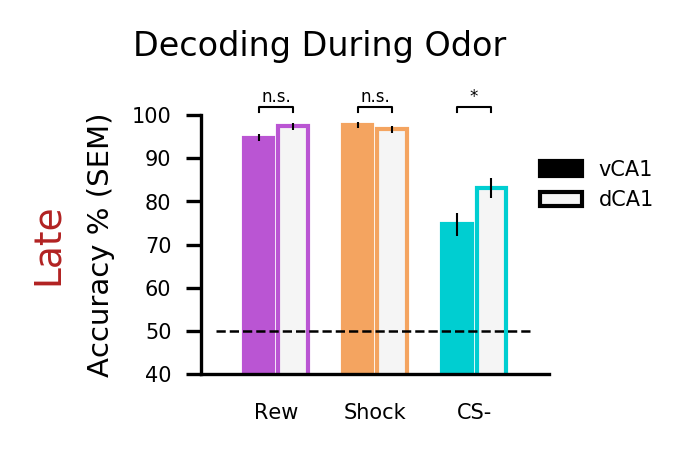

In [124]:
from matplotlib.patches import Patch
labels = ['Rew','Shock','CS-']
x = np.arange(len(labels))  # the label locations
width = 0.3# the width of the bars
loops=10
r={}
s={}
p={}
#to_plot = [0,1]
fig, ax = pl.subplots(figsize=(1.9,1.4))

            
r[sess] = np.array(np.std(baseline_scores_tb_4_rw_vhpc['post'][-loops:])*100/np.sqrt(loops-1))
ax.bar(-width/2-.025, np.mean(baseline_scores_tb_4_rw_vhpc['post'][-loops:])*100, width, edgecolor='mediumorchid',color='mediumorchid',yerr=r[sess])
p[sess] = np.array(np.std(baseline_scores_tb_4_rw_dhpc['post'][-loops:])*100/np.sqrt(loops-1))
ax.bar(width/2+.025,  np.mean(baseline_scores_tb_4_rw_dhpc['post'][-loops:])*100, width,edgecolor='mediumorchid',color='whitesmoke',yerr=p[sess])
r[sess] = np.array(np.std(baseline_scores_tb_4_sh_vhpc['post'][-loops:])*100/np.sqrt(loops-1))
ax.bar(1-width/2-.025, np.mean(baseline_scores_tb_4_sh_vhpc['post'][-loops:])*100, width, edgecolor='sandybrown',color='sandybrown',yerr=r[sess])
p[sess] = np.array(np.std(baseline_scores_tb_4_sh_dhpc['post'][-loops:])*100/np.sqrt(loops-1))
ax.bar(1+width/2+.025,  np.mean(baseline_scores_tb_4_sh_dhpc['post'][-loops:])*100, width,edgecolor='sandybrown',color='whitesmoke',yerr=p[sess])
r[sess] = np.array(np.std(baseline_scores_tb_4_csm_vhpc['post'][-loops:])*100/np.sqrt(loops-1))
ax.bar(2-width/2-.025, np.mean(baseline_scores_tb_4_csm_vhpc['post'][-loops:])*100, width, edgecolor='darkturquoise',color='darkturquoise',yerr=r[sess])
p[sess] = np.array(np.std(baseline_scores_tb_4_csm_dhpc['post'][-loops:])*100/np.sqrt(loops-1))
ax.bar(2+width/2+.025,  np.mean(baseline_scores_tb_4_csm_dhpc['post'][-loops:])*100, width,edgecolor='darkturquoise',color='whitesmoke',yerr=p[sess])

ax.hlines(50,-.6,2.6, color='k', lw=.6, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy % (SEM)')
#ax.set_title('Decoding During CS')
ax.set_ylim(40,100)
ax.set_xticks([0,1,2])
ax.set_xticklabels(labels)
ax.legend([Patch(edgecolor='k',facecolor='k'),Patch(edgecolor='k',facecolor='whitesmoke')],
          ['vCA1','dCA1'],loc=(.95,.6),frameon=False)
ax.tick_params(axis='x',bottom=False)
pvs=[]
for reg,i in zip(['rw','sh','csm'], [0,1,2]):
    pvs.append(add_significance(ax,eval("baseline_scores_tb_4_%s_vhpc['post'][-loops:]"%reg), eval("baseline_scores_tb_4_%s_dhpc['post'][-loops:]"%reg),
        -width/2-.025+i,width/2+.025+i,102,mcc=2))
    #pvs.append(add_significance(ax,eval("baseline_scores_tb_4_sh_%s['post'][-loops:]"%reg), eval("baseline_scores_tb_4_csm_%s['post'][-loops:]"%reg),
    #    i+.03,width/3+.25+i,100,mcc=2))
    #pvs.append(add_significance(ax,eval("baseline_scores_tb_4_rw_%s['post'][-loops:]"%reg), eval("baseline_scores_tb_4_csm_%s['post'][-loops:]"%reg),
    #    -width/3-.25+i,width/3+.25+i,105,mcc=2))

pl.suptitle('Decoding During Odor',y=1.06,fontsize=8)
ax.text(-2.3,70,'Late',rotation=90,fontsize=9,color='firebrick',ha='center',va='center')
fig.tight_layout(pad=2.5)

fig.savefig('../figures/%s_bars_odor_Late_dVSv.pdf'%NOTEBOOK_NAME)

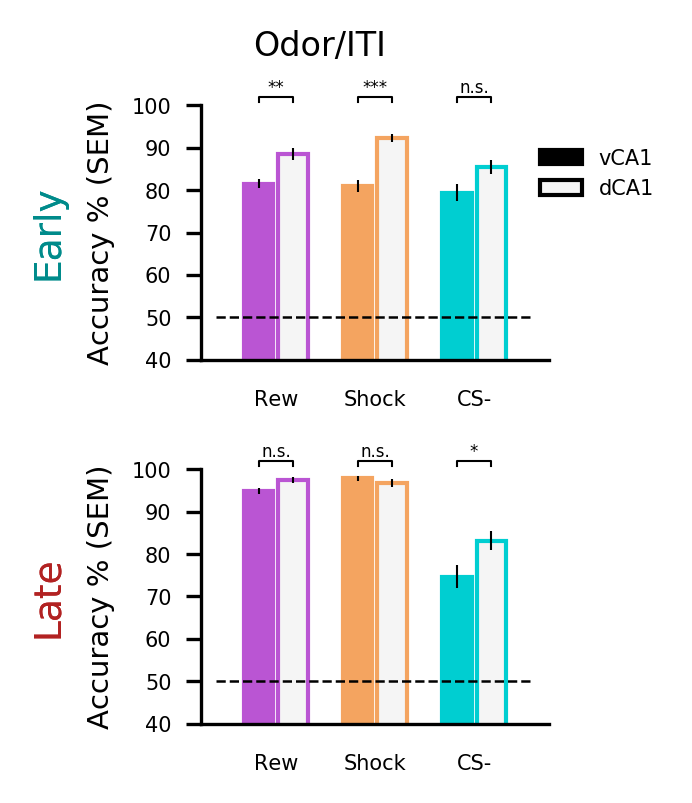

In [162]:
from matplotlib.patches import Patch
labels = ['Rew','Shock','CS-']
x = np.arange(len(labels))  # the label locations
width = 0.3# the width of the bars
loops=10
r={}
s={}
p={}
#to_plot = [0,1]
fig, ax = pl.subplots(2,1,figsize=(1.9,2.6))

for c,sess in zip (range(2),['pre','post']):
    
    r[sess] = np.array(np.std(baseline_scores_tb_4_rw_vhpc[sess][-loops:])*100/np.sqrt(loops-1))
    ax[c].bar(-width/2-.025, np.mean(baseline_scores_tb_4_rw_vhpc[sess][-loops:])*100, width, edgecolor='mediumorchid',color='mediumorchid',yerr=r[sess])
    p[sess] = np.array(np.std(baseline_scores_tb_4_rw_dhpc[sess][-loops:])*100/np.sqrt(loops-1))
    ax[c].bar(width/2+.025,  np.mean(baseline_scores_tb_4_rw_dhpc[sess][-loops:])*100, width,edgecolor='mediumorchid',color='whitesmoke',yerr=p[sess])
    r[sess] = np.array(np.std(baseline_scores_tb_4_sh_vhpc[sess][-loops:])*100/np.sqrt(loops-1))
    ax[c].bar(1-width/2-.025, np.mean(baseline_scores_tb_4_sh_vhpc[sess][-loops:])*100, width, edgecolor='sandybrown',color='sandybrown',yerr=r[sess])
    p[sess] = np.array(np.std(baseline_scores_tb_4_sh_dhpc[sess][-loops:])*100/np.sqrt(loops-1))
    ax[c].bar(1+width/2+.025,  np.mean(baseline_scores_tb_4_sh_dhpc[sess][-loops:])*100, width,edgecolor='sandybrown',color='whitesmoke',yerr=p[sess])
    r[sess] = np.array(np.std(baseline_scores_tb_4_csm_vhpc[sess][-loops:])*100/np.sqrt(loops-1))
    ax[c].bar(2-width/2-.025, np.mean(baseline_scores_tb_4_csm_vhpc[sess][-loops:])*100, width, edgecolor='darkturquoise',color='darkturquoise',yerr=r[sess])
    p[sess] = np.array(np.std(baseline_scores_tb_4_csm_dhpc[sess][-loops:])*100/np.sqrt(loops-1))
    ax[c].bar(2+width/2+.025,  np.mean(baseline_scores_tb_4_csm_dhpc[sess][-loops:])*100, width,edgecolor='darkturquoise',color='whitesmoke',yerr=p[sess])
    
    ax[c].hlines(50,-.6,2.6, color='k', lw=.6, linestyles='dashed')
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax[c].set_ylabel('Accuracy % (SEM)')
    #ax.set_title('Decoding During CS')
    ax[c].set_ylim(40,100)
    ax[c].set_xticks([0,1,2])
    ax[c].set_xticklabels(labels)
    ax[0].legend([Patch(edgecolor='k',facecolor='k'),Patch(edgecolor='k',facecolor='whitesmoke')],
              ['vCA1','dCA1'],loc=(.95,.6),frameon=False)
    ax[c].tick_params(axis='x',bottom=False)
    ax[0].text(-2.3,70,'Early',rotation=90,fontsize=9,color='darkcyan',ha='center',va='center')
    ax[1].text(-2.3,70,'Late',rotation=90,fontsize=9,color='firebrick',ha='center',va='center')
pvs=[]
for reg,i in zip(['rw','sh','csm'], [0,1,2]):
    for c,sess in zip(range(2),['pre','post']):
        pvs.append(add_significance(ax[c],eval("baseline_scores_tb_4_%s_vhpc[sess][-loops:]"%reg), eval("baseline_scores_tb_4_%s_dhpc[sess][-loops:]"%reg),
                -width/2-.025+i,width/2+.025+i,102,mcc=2))
        #pvs.append(add_significance(ax,eval("baseline_scores_tb_4_sh_%s[sess][-loops:]"%reg), eval("baseline_scores_tb_4_csm_%s[sess][-loops:]"%reg),
        #    i+.03,width/3+.25+i,100,mcc=2))
        #pvs.append(add_significance(ax,eval("baseline_scores_tb_4_rw_%s[sess][-loops:]"%reg), eval("baseline_scores_tb_4_csm_%s[sess][-loops:]"%reg),
        #    -width/3-.25+i,width/3+.25+i,105,mcc=2))
    
    pl.suptitle('Odor/ITI',y=1.02,fontsize=8)
fig.tight_layout(pad=2.5)

fig.savefig('../figures/%s_bars_odor_PrPo_dVSv.pdf'%NOTEBOOK_NAME)

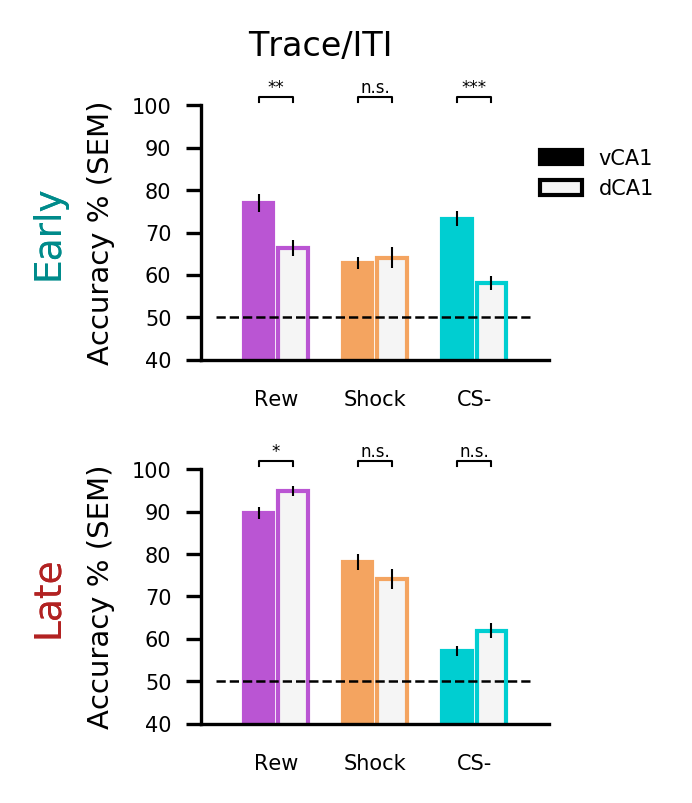

In [161]:
from matplotlib.patches import Patch
labels = ['Rew','Shock','CS-']
x = np.arange(len(labels))  # the label locations
width = 0.3# the width of the bars
loops=10
r={}
s={}
p={}
#to_plot = [0,1]
fig, ax = pl.subplots(2,1,figsize=(1.9,2.6))

for c,sess in zip (range(2),['pre','post']):
    
    r[sess] = np.array(np.std(baseline_scores_tb_6_rw_vhpc[sess][-loops:])*100/np.sqrt(loops-1))
    ax[c].bar(-width/2-.025, np.mean(baseline_scores_tb_6_rw_vhpc[sess][-loops:])*100, width, edgecolor='mediumorchid',color='mediumorchid',yerr=r[sess])
    p[sess] = np.array(np.std(baseline_scores_tb_6_rw_dhpc[sess][-loops:])*100/np.sqrt(loops-1))
    ax[c].bar(width/2+.025,  np.mean(baseline_scores_tb_6_rw_dhpc[sess][-loops:])*100, width,edgecolor='mediumorchid',color='whitesmoke',yerr=p[sess])
    r[sess] = np.array(np.std(baseline_scores_tb_6_sh_vhpc[sess][-loops:])*100/np.sqrt(loops-1))
    ax[c].bar(1-width/2-.025, np.mean(baseline_scores_tb_6_sh_vhpc[sess][-loops:])*100, width, edgecolor='sandybrown',color='sandybrown',yerr=r[sess])
    p[sess] = np.array(np.std(baseline_scores_tb_6_sh_dhpc[sess][-loops:])*100/np.sqrt(loops-1))
    ax[c].bar(1+width/2+.025,  np.mean(baseline_scores_tb_6_sh_dhpc[sess][-loops:])*100, width,edgecolor='sandybrown',color='whitesmoke',yerr=p[sess])
    r[sess] = np.array(np.std(baseline_scores_tb_6_csm_vhpc[sess][-loops:])*100/np.sqrt(loops-1))
    ax[c].bar(2-width/2-.025, np.mean(baseline_scores_tb_6_csm_vhpc[sess][-loops:])*100, width, edgecolor='darkturquoise',color='darkturquoise',yerr=r[sess])
    p[sess] = np.array(np.std(baseline_scores_tb_6_csm_dhpc[sess][-loops:])*100/np.sqrt(loops-1))
    ax[c].bar(2+width/2+.025,  np.mean(baseline_scores_tb_6_csm_dhpc[sess][-loops:])*100, width,edgecolor='darkturquoise',color='whitesmoke',yerr=p[sess])
    
    ax[c].hlines(50,-.6,2.6, color='k', lw=.6, linestyles='dashed')
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax[c].set_ylabel('Accuracy % (SEM)')
    #ax.set_title('Decoding During CS')
    ax[c].set_ylim(40,100)
    ax[c].set_xticks([0,1,2])
    ax[c].set_xticklabels(labels)
    ax[0].legend([Patch(edgecolor='k',facecolor='k'),Patch(edgecolor='k',facecolor='whitesmoke')],
              ['vCA1','dCA1'],loc=(.95,.6),frameon=False)
    ax[c].tick_params(axis='x',bottom=False)
    ax[0].text(-2.3,70,'Early',rotation=90,fontsize=9,color='darkcyan',ha='center',va='center')
    ax[1].text(-2.3,70,'Late',rotation=90,fontsize=9,color='firebrick',ha='center',va='center')
pvs=[]
for reg,i in zip(['rw','sh','csm'], [0,1,2]):
    for c,sess in zip(range(2),['pre','post']):
        pvs.append(add_significance(ax[c],eval("baseline_scores_tb_6_%s_vhpc[sess][-loops:]"%reg), eval("baseline_scores_tb_6_%s_dhpc[sess][-loops:]"%reg),
                -width/2-.025+i,width/2+.025+i,102,mcc=2))
        #pvs.append(add_significance(ax,eval("baseline_scores_tb_6_sh_%s[sess][-loops:]"%reg), eval("baseline_scores_tb_6_csm_%s[sess][-loops:]"%reg),
        #    i+.03,width/3+.25+i,100,mcc=2))
        #pvs.append(add_significance(ax,eval("baseline_scores_tb_6_rw_%s[sess][-loops:]"%reg), eval("baseline_scores_tb_6_csm_%s[sess][-loops:]"%reg),
        #    -width/3-.25+i,width/3+.25+i,105,mcc=2))
    
    pl.suptitle('Trace/ITI',y=1.02,fontsize=8)
fig.tight_layout(pad=2.5)

fig.savefig('../figures/%s_bars_tr_PrPo_dVSv.pdf'%NOTEBOOK_NAME)

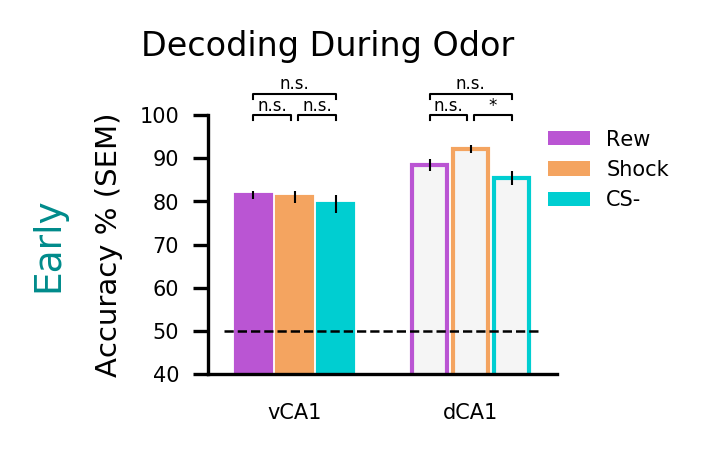

In [112]:
from matplotlib.patches import Patch
labels = ['vCA1','dCA1']
x = np.arange(len(labels))  # the label locations
width = 0.3# the width of the bars
loops=10
r={}
s={}
p={}
to_plot = [0,1]
fig, ax = pl.subplots(figsize=(1.9,1.4))

            
r[sess] = np.array(np.std(baseline_scores_tb_4_rw_vhpc['pre'][-loops:])*100/np.sqrt(loops-1))
ax.bar(-width/3-.25, np.mean(baseline_scores_tb_4_rw_vhpc['pre'][-loops:])*100, width, edgecolor='mediumorchid',color='mediumorchid',yerr=r[sess])
s[sess] = np.array(np.std(baseline_scores_tb_4_sh_vhpc['pre'][-loops:])*100/np.sqrt(loops-1))
ax.bar(0,  np.mean(baseline_scores_tb_4_sh_vhpc['pre'][-loops:])*100, width,edgecolor='sandybrown',color='sandybrown',yerr=s[sess])
p[sess] = np.array(np.std(baseline_scores_tb_4_csm_vhpc['pre'][-loops:])*100/np.sqrt(loops-1))
ax.bar(width/3+.25,  np.mean(baseline_scores_tb_4_csm_vhpc['pre'][-loops:])*100, width,edgecolor='darkturquoise',color='darkturquoise',yerr=p[sess])
r[sess] = np.array(np.std(baseline_scores_tb_4_rw_dhpc['pre'][-loops:])*100/np.sqrt(loops-1))
ax.bar(1.5-width/3-.25, np.mean(baseline_scores_tb_4_rw_dhpc['pre'][-loops:])*100, width, edgecolor='mediumorchid',color='whitesmoke',yerr=r[sess])
s[sess] = np.array(np.std(baseline_scores_tb_4_sh_dhpc['pre'][-loops:])*100/np.sqrt(loops-1))
ax.bar(1.5,  np.mean(baseline_scores_tb_4_sh_dhpc['pre'][-loops:])*100, width,edgecolor='sandybrown',color='whitesmoke',yerr=s[sess])
p[sess] = np.array(np.std(baseline_scores_tb_4_csm_dhpc['pre'][-loops:])*100/np.sqrt(loops-1))
ax.bar(1.5+width/3+.25,  np.mean(baseline_scores_tb_4_csm_dhpc['pre'][-loops:])*100, width,edgecolor='darkturquoise',color='whitesmoke',yerr=p[sess])
ax.hlines(50,-.6,2.1, color='k', lw=.6, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy % (SEM)')
#ax.set_title('Decoding During CS')
ax.set_ylim(40,100)
ax.set_xticks([0,1.5])
ax.set_xticklabels(labels)
ax.legend([Patch(facecolor='mediumorchid'),Patch(facecolor='sandybrown'),Patch(facecolor='darkturquoise')],
          ['Rew','Shock','CS-'],loc=(.95,.6),frameon=False)
ax.tick_params(axis='x',bottom=False)
pvs=[]
for reg,i in zip(['vhpc','dhpc'], [0,1.5]):
    pvs.append(add_significance(ax,eval("baseline_scores_tb_4_rw_%s['pre'][-loops:]"%reg), eval("baseline_scores_tb_4_sh_%s['pre'][-loops:]"%reg),
        -width/3-.25+i,i-.03,100,mcc=2))
    pvs.append(add_significance(ax,eval("baseline_scores_tb_4_sh_%s['pre'][-loops:]"%reg), eval("baseline_scores_tb_4_csm_%s['pre'][-loops:]"%reg),
        i+.03,width/3+.25+i,100,mcc=2))
    pvs.append(add_significance(ax,eval("baseline_scores_tb_4_rw_%s['pre'][-loops:]"%reg), eval("baseline_scores_tb_4_csm_%s['pre'][-loops:]"%reg),
        -width/3-.25+i,width/3+.25+i,105,mcc=2))

pl.suptitle('Decoding During Odor',y=1.06,fontsize=8)
ax.text(-2.1,70,'Early',rotation=90,fontsize=9,color='darkcyan',ha='center',va='center')
fig.tight_layout(pad=2.5)

fig.savefig('../figures/%s_bars_odor_Early.pdf'%NOTEBOOK_NAME)

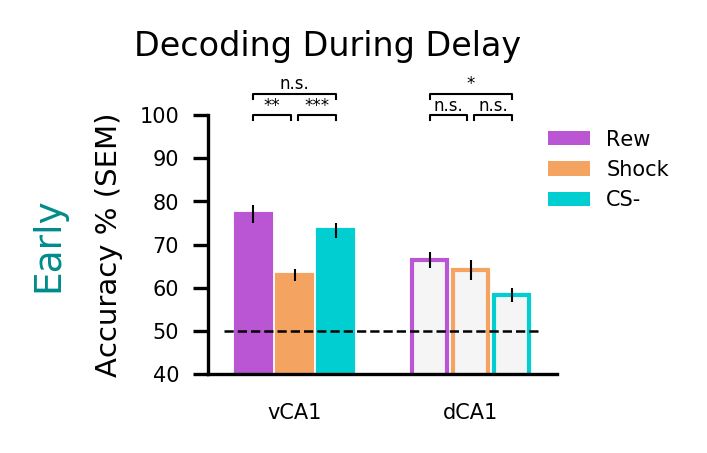

In [113]:
from matplotlib.patches import Patch
labels = ['vCA1','dCA1']
x = np.arange(len(labels))  # the label locations
width = 0.3# the width of the bars
loops=10
r={}
s={}
p={}
to_plot = [0,1]
fig, ax = pl.subplots(figsize=(1.9,1.4))

            
r[sess] = np.array(np.std(baseline_scores_tb_6_rw_vhpc['pre'][-loops:])*100/np.sqrt(loops-1))
ax.bar(-width/3-.25, np.mean(baseline_scores_tb_6_rw_vhpc['pre'][-loops:])*100, width, edgecolor='mediumorchid',color='mediumorchid',yerr=r[sess])
s[sess] = np.array(np.std(baseline_scores_tb_6_sh_vhpc['pre'][-loops:])*100/np.sqrt(loops-1))
ax.bar(0,  np.mean(baseline_scores_tb_6_sh_vhpc['pre'][-loops:])*100, width,edgecolor='sandybrown',color='sandybrown',yerr=s[sess])
p[sess] = np.array(np.std(baseline_scores_tb_6_csm_vhpc['pre'][-loops:])*100/np.sqrt(loops-1))
ax.bar(width/3+.25,  np.mean(baseline_scores_tb_6_csm_vhpc['pre'][-loops:])*100, width,edgecolor='darkturquoise',color='darkturquoise',yerr=p[sess])
r[sess] = np.array(np.std(baseline_scores_tb_6_rw_dhpc['pre'][-loops:])*100/np.sqrt(loops-1))
ax.bar(1.5-width/3-.25, np.mean(baseline_scores_tb_6_rw_dhpc['pre'][-loops:])*100, width, edgecolor='mediumorchid',color='whitesmoke',yerr=r[sess])
s[sess] = np.array(np.std(baseline_scores_tb_6_sh_dhpc['pre'][-loops:])*100/np.sqrt(loops-1))
ax.bar(1.5,  np.mean(baseline_scores_tb_6_sh_dhpc['pre'][-loops:])*100, width,edgecolor='sandybrown',color='whitesmoke',yerr=s[sess])
p[sess] = np.array(np.std(baseline_scores_tb_6_csm_dhpc['pre'][-loops:])*100/np.sqrt(loops-1))
ax.bar(1.5+width/3+.25,  np.mean(baseline_scores_tb_6_csm_dhpc['pre'][-loops:])*100, width,edgecolor='darkturquoise',color='whitesmoke',yerr=p[sess])
ax.hlines(50,-.6,2.1, color='k', lw=.6, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy % (SEM)')
#ax.set_title('Decoding During CS')
ax.set_ylim(40,100)
ax.set_xticks([0,1.5])
ax.set_xticklabels(labels)
ax.legend([Patch(facecolor='mediumorchid'),Patch(facecolor='sandybrown'),Patch(facecolor='darkturquoise')],
          ['Rew','Shock','CS-'],loc=(.95,.6),frameon=False)
ax.tick_params(axis='x',bottom=False)
pvs=[]
for reg,i in zip(['vhpc','dhpc'], [0,1.5]):
    pvs.append(add_significance(ax,eval("baseline_scores_tb_6_rw_%s['pre'][-loops:]"%reg), eval("baseline_scores_tb_6_sh_%s['pre'][-loops:]"%reg),
        -width/3-.25+i,i-.03,100,mcc=2))
    pvs.append(add_significance(ax,eval("baseline_scores_tb_6_sh_%s['pre'][-loops:]"%reg), eval("baseline_scores_tb_6_csm_%s['pre'][-loops:]"%reg),
        i+.03,width/3+.25+i,100,mcc=2))
    pvs.append(add_significance(ax,eval("baseline_scores_tb_6_rw_%s['pre'][-loops:]"%reg), eval("baseline_scores_tb_6_csm_%s['pre'][-loops:]"%reg),
        -width/3-.25+i,width/3+.25+i,105,mcc=2))

pl.suptitle('Decoding During Delay',y=1.06,fontsize=8)
ax.text(-2.1,70,'Early',rotation=90,fontsize=9,color='darkcyan',ha='center',va='center')
fig.tight_layout(pad=2.5)

fig.savefig('../figures/%s_bars_tr_Early.pdf'%NOTEBOOK_NAME)

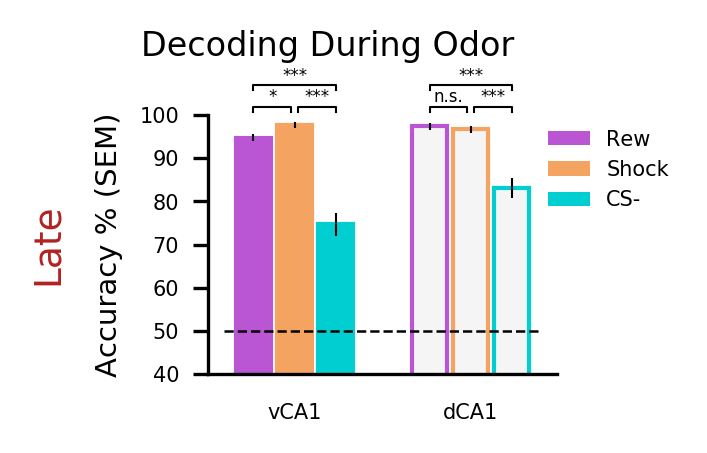

In [114]:
from matplotlib.patches import Patch
labels = ['vCA1','dCA1']
x = np.arange(len(labels))  # the label locations
width = 0.3# the width of the bars
loops=10
r={}
s={}
p={}
to_plot = [0,1]
fig, ax = pl.subplots(figsize=(1.9,1.4))

            
r[sess] = np.array(np.std(baseline_scores_tb_4_rw_vhpc['post'][-loops:])*100/np.sqrt(loops-1))
ax.bar(-width/3-.25, np.mean(baseline_scores_tb_4_rw_vhpc['post'][-loops:])*100, width, edgecolor='mediumorchid',color='mediumorchid',yerr=r[sess])
s[sess] = np.array(np.std(baseline_scores_tb_4_sh_vhpc['post'][-loops:])*100/np.sqrt(loops-1))
ax.bar(0,  np.mean(baseline_scores_tb_4_sh_vhpc['post'][-loops:])*100, width,edgecolor='sandybrown',color='sandybrown',yerr=s[sess])
p[sess] = np.array(np.std(baseline_scores_tb_4_csm_vhpc['post'][-loops:])*100/np.sqrt(loops-1))
ax.bar(width/3+.25,  np.mean(baseline_scores_tb_4_csm_vhpc['post'][-loops:])*100, width,edgecolor='darkturquoise',color='darkturquoise',yerr=p[sess])
r[sess] = np.array(np.std(baseline_scores_tb_4_rw_dhpc['post'][-loops:])*100/np.sqrt(loops-1))
ax.bar(1.5-width/3-.25, np.mean(baseline_scores_tb_4_rw_dhpc['post'][-loops:])*100, width, edgecolor='mediumorchid',color='whitesmoke',yerr=r[sess])
s[sess] = np.array(np.std(baseline_scores_tb_4_sh_dhpc['post'][-loops:])*100/np.sqrt(loops-1))
ax.bar(1.5,  np.mean(baseline_scores_tb_4_sh_dhpc['post'][-loops:])*100, width,edgecolor='sandybrown',color='whitesmoke',yerr=s[sess])
p[sess] = np.array(np.std(baseline_scores_tb_4_csm_dhpc['post'][-loops:])*100/np.sqrt(loops-1))
ax.bar(1.5+width/3+.25,  np.mean(baseline_scores_tb_4_csm_dhpc['post'][-loops:])*100, width,edgecolor='darkturquoise',color='whitesmoke',yerr=p[sess])
ax.hlines(50,-.6,2.1, color='k', lw=.6, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy % (SEM)')
#ax.set_title('Decoding During CS')
ax.set_ylim(40,100)
ax.set_xticks([0,1.5])
ax.set_xticklabels(labels)
ax.legend([Patch(facecolor='mediumorchid'),Patch(facecolor='sandybrown'),Patch(facecolor='darkturquoise')],
          ['Rew','Shock','CS-'],loc=(.95,.6),frameon=False)
ax.tick_params(axis='x',bottom=False)
pvs=[]
for reg,i in zip(['vhpc','dhpc'], [0,1.5]):
    pvs.append(add_significance(ax,eval("baseline_scores_tb_4_rw_%s['post'][-loops:]"%reg), eval("baseline_scores_tb_4_sh_%s['post'][-loops:]"%reg),
        -width/3-.25+i,i-.03,102,mcc=2))
    pvs.append(add_significance(ax,eval("baseline_scores_tb_4_sh_%s['post'][-loops:]"%reg), eval("baseline_scores_tb_4_csm_%s['post'][-loops:]"%reg),
        i+.03,width/3+.25+i,102,mcc=2))
    pvs.append(add_significance(ax,eval("baseline_scores_tb_4_rw_%s['post'][-loops:]"%reg), eval("baseline_scores_tb_4_csm_%s['post'][-loops:]"%reg),
        -width/3-.25+i,width/3+.25+i,107,mcc=2))

pl.suptitle('Decoding During Odor',y=1.06,fontsize=8)
ax.text(-2.1,70,'Late',rotation=90,fontsize=9,color='firebrick',ha='center',va='center')
fig.tight_layout(pad=2.5)

fig.savefig('../figures/%s_bars_odor_Late.pdf'%NOTEBOOK_NAME)

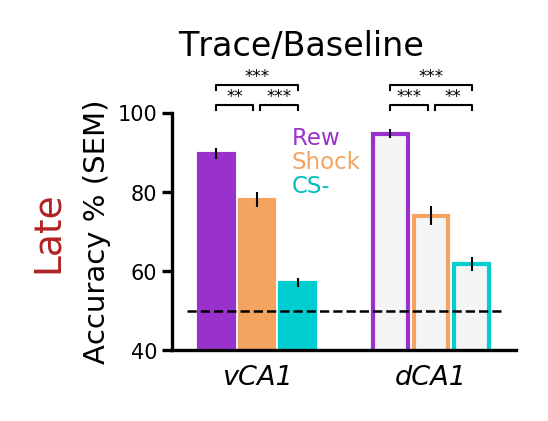

In [171]:
from matplotlib.patches import Patch
labels = ['vCA1','dCA1']
x = np.arange(len(labels))  # the label locations
width = 0.3# the width of the bars
loops=10
r={}
s={}
p={}
to_plot = [0,1]
fig, ax = pl.subplots(figsize=(1.8,1.3))

            
r[sess] = np.array(np.std(baseline_scores_tb_6_rw_vhpc['post'][-loops:])*100/np.sqrt(loops-1))
ax.bar(-width/3-.25, np.mean(baseline_scores_tb_6_rw_vhpc['post'][-loops:])*100, width, edgecolor='darkorchid',color='darkorchid',yerr=r[sess])
s[sess] = np.array(np.std(baseline_scores_tb_6_sh_vhpc['post'][-loops:])*100/np.sqrt(loops-1))
ax.bar(0,  np.mean(baseline_scores_tb_6_sh_vhpc['post'][-loops:])*100, width,edgecolor='sandybrown',color='sandybrown',yerr=s[sess])
p[sess] = np.array(np.std(baseline_scores_tb_6_csm_vhpc['post'][-loops:])*100/np.sqrt(loops-1))
ax.bar(width/3+.25,  np.mean(baseline_scores_tb_6_csm_vhpc['post'][-loops:])*100, width,edgecolor='darkturquoise',color='darkturquoise',yerr=p[sess])
r[sess] = np.array(np.std(baseline_scores_tb_6_rw_dhpc['post'][-loops:])*100/np.sqrt(loops-1))
ax.bar(1.5-width/3-.25, np.mean(baseline_scores_tb_6_rw_dhpc['post'][-loops:])*100, width, edgecolor='darkorchid',color='whitesmoke',yerr=r[sess])
s[sess] = np.array(np.std(baseline_scores_tb_6_sh_dhpc['post'][-loops:])*100/np.sqrt(loops-1))
ax.bar(1.5,  np.mean(baseline_scores_tb_6_sh_dhpc['post'][-loops:])*100, width,edgecolor='sandybrown',color='whitesmoke',yerr=s[sess])
p[sess] = np.array(np.std(baseline_scores_tb_6_csm_dhpc['post'][-loops:])*100/np.sqrt(loops-1))
ax.bar(1.5+width/3+.25,  np.mean(baseline_scores_tb_6_csm_dhpc['post'][-loops:])*100, width,edgecolor='darkturquoise',color='whitesmoke',yerr=p[sess])
ax.hlines(50,-.6,2.1, color='k', lw=.6, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy % (SEM)',labelpad=1.5)
#ax.set_title('Decoding During CS')
ax.set_ylim(40,100)
ax.set_xticks([0,1.5])
ax.set_xticklabels(labels,fontstyle='italic',fontsize=6.5)
#ax.legend([Patch(facecolor='darkorchid'),Patch(facecolor='sandybrown'),Patch(facecolor='darkturquoise')],
#          ['Rew','Shock','CS-'],loc=(.95,.6),frameon=False)
ax.text(.3,92,'Rew',color='darkorchid',fontsize=5.5)
ax.text(.3,86,'Shock',color='sandybrown',fontsize=5.5)
ax.text(.3,80,'CS-',color='c',fontsize=5.5)
ax.tick_params(axis='both',bottom=False,pad=1,length=2.5)
pvs=[]
for reg,i in zip(['vhpc','dhpc'], [0,1.5]):
    pvs.append(add_significance(ax,eval("baseline_scores_tb_6_rw_%s['post'][-loops:]"%reg), eval("baseline_scores_tb_6_sh_%s['post'][-loops:]"%reg),
        -width/3-.25+i,i-.03,102,mcc=2))
    pvs.append(add_significance(ax,eval("baseline_scores_tb_6_sh_%s['post'][-loops:]"%reg), eval("baseline_scores_tb_6_csm_%s['post'][-loops:]"%reg),
        i+.03,width/3+.25+i,102,mcc=2))
    pvs.append(add_significance(ax,eval("baseline_scores_tb_6_rw_%s['post'][-loops:]"%reg), eval("baseline_scores_tb_6_csm_%s['post'][-loops:]"%reg),
        -width/3-.25+i,width/3+.25+i,107,mcc=2))

pl.suptitle('Trace/Baseline',y=1.06,fontsize=8)
ax.text(-1.8,70,'Late',rotation=90,fontsize=9,color='firebrick',ha='center',va='center')
fig.tight_layout(pad=2.5)

fig.savefig('../figures/%s_bars_tr_Late.pdf'%NOTEBOOK_NAME)

vhpc rw/sh U = 100.0 p = 0.000351231062092 r = 0.845154254729
None
vhpc rw/CS- U = 100.0 p = 0.000353222023338 r = 0.845154254729
None
vhpc sh/CS- U = 97.0 p = 0.000874909842326 r = 0.794444999445
None
dhpc rw/sh U = 17.5 p = 0.0304318231243 r = -0.549350265574
None
dhpc rw/CS- U = 27.5 p = 0.190854899396 r = -0.380319414628
None
dhpc sh/CS- U = 55.5 p = 1.40900470702 r = 0.0929669680201
None


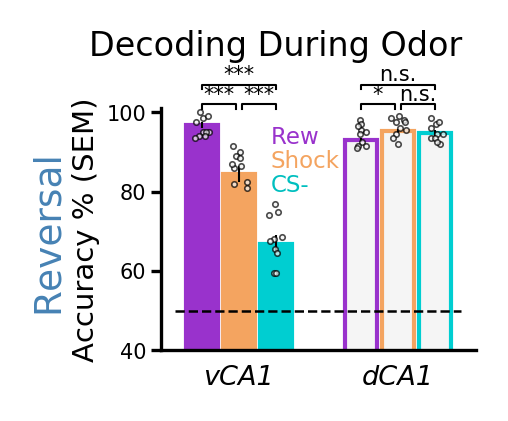

In [14]:
from matplotlib.patches import Patch
labels = ['vCA1','dCA1']
x = np.arange(len(labels))  # the label locations
width = 0.3# the width of the bars
loops=10
r={}
s={}
p={}
to_plot = [0,1]
fig, ax = pl.subplots(figsize=(1.7,1.3))

            
r[sess] = np.array(np.std(baseline_scores_tb_4_rw_vhpc['post_rev'][-loops:])*100/np.sqrt(loops-1))
ax.bar(-width/3-.25, np.mean(baseline_scores_tb_4_rw_vhpc['post_rev'][-loops:])*100, width, edgecolor='darkorchid',color='darkorchid',yerr=r[sess])
ax.scatter(-width/3-.25+np.random.random(loops)*width/2-width/4.5, baseline_scores_tb_4_rw_vhpc['post_rev'][:loops]*100, color='whitesmoke',
           s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
s[sess] = np.array(np.std(baseline_scores_tb_4_sh_vhpc['post_rev'][-loops:])*100/np.sqrt(loops-1))
ax.bar(0,  np.mean(baseline_scores_tb_4_sh_vhpc['post_rev'][-loops:])*100, width,edgecolor='sandybrown',color='sandybrown',yerr=s[sess])
ax.scatter(0+np.random.random(loops)*width/2-width/4.5, baseline_scores_tb_4_sh_vhpc['post_rev'][:loops]*100, color='whitesmoke',
           s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
p[sess] = np.array(np.std(baseline_scores_tb_4_csm_vhpc['post_rev'][-loops:])*100/np.sqrt(loops-1))
ax.bar(width/3+.25,  np.mean(baseline_scores_tb_4_csm_vhpc['post_rev'][-loops:])*100, width,edgecolor='darkturquoise',color='darkturquoise',yerr=p[sess])
ax.scatter(width/3+.25+np.random.random(loops)*width/2-width/4.5, baseline_scores_tb_4_csm_vhpc['post_rev'][:loops]*100, color='whitesmoke',
           s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
r[sess] = np.array(np.std(baseline_scores_tb_4_rw_dhpc['post_rev'][-loops:])*100/np.sqrt(loops-1))
ax.bar(1.5-width/3-.25, np.mean(baseline_scores_tb_4_rw_dhpc['post_rev'][-loops:])*100, width, edgecolor='darkorchid',color='whitesmoke',yerr=r[sess])
ax.scatter(1.5-width/3-.25+np.random.random(loops)*width/2-width/4.5, baseline_scores_tb_4_rw_dhpc['post_rev'][:loops]*100, color='whitesmoke',
           s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
s[sess] = np.array(np.std(baseline_scores_tb_4_sh_dhpc['post_rev'][-loops:])*100/np.sqrt(loops-1))
ax.bar(1.5,  np.mean(baseline_scores_tb_4_sh_dhpc['post_rev'][-loops:])*100, width,edgecolor='sandybrown',color='whitesmoke',yerr=s[sess])
ax.scatter(1.5+np.random.random(loops)*width/2-width/4.5, baseline_scores_tb_4_sh_dhpc['post_rev'][:loops]*100, color='whitesmoke',
           s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
p[sess] = np.array(np.std(baseline_scores_tb_4_csm_dhpc['post_rev'][-loops:])*100/np.sqrt(loops-1))
ax.bar(1.5+width/3+.25,  np.mean(baseline_scores_tb_4_csm_dhpc['post_rev'][-loops:])*100, width,edgecolor='darkturquoise',color='whitesmoke',yerr=p[sess])
ax.scatter(1.5+width/3+.25+np.random.random(loops)*width/2-width/4.5, baseline_scores_tb_4_csm_dhpc['post_rev'][:loops]*100, color='whitesmoke',
           s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')

ax.hlines(50,-.6,2.1, color='k', lw=.6, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy % (SEM)',labelpad=1.5)
#ax.set_title('Decoding During CS')
ax.set_ylim(40,101)
ax.set_xticks([0,1.5])
ax.set_xticklabels(labels,fontstyle='italic',fontsize=6.5)
#ax.legend([Patch(facecolor='darkorchid'),Patch(facecolor='sandybrown'),Patch(facecolor='darkturquoise')],
#          ['Rew','Shock','CS-'],loc=(.95,.6),frameon=False)
ax.text(.3,92,'Rew',color='darkorchid',fontsize=5.5)
ax.text(.3,86,'Shock',color='sandybrown',fontsize=5.5)
ax.text(.3,80,'CS-',color='c',fontsize=5.5)
ax.tick_params(axis='both',bottom=False,pad=1,length=2.5)
pvs=[]
for reg,i in zip(['vhpc','dhpc'], [0,1.5]):
    pvs.append(add_significance(ax,eval("baseline_scores_tb_4_rw_%s['post_rev'][-loops:]"%reg), eval("baseline_scores_tb_4_sh_%s['post_rev'][-loops:]"%reg),
        -width/3-.25+i,i-.03,102,mcc=2))
    pvs.append(add_significance(ax,eval("baseline_scores_tb_4_sh_%s['post_rev'][-loops:]"%reg), eval("baseline_scores_tb_4_csm_%s['post_rev'][-loops:]"%reg),
        i+.03,width/3+.25+i,102,mcc=2))
    pvs.append(add_significance(ax,eval("baseline_scores_tb_4_rw_%s['post_rev'][-loops:]"%reg), eval("baseline_scores_tb_4_csm_%s['post_rev'][-loops:]"%reg),
        -width/3-.25+i,width/3+.25+i,107,mcc=2))
    print reg,'rw/sh',report_stats(eval("baseline_scores_tb_4_rw_%s['post_rev'][-loops:]"%reg), eval("baseline_scores_tb_4_sh_%s['post_rev'][-loops:]"%reg),mcc=2)
    print reg,'rw/CS-',report_stats(eval("baseline_scores_tb_4_rw_%s['post_rev'][-loops:]"%reg), eval("baseline_scores_tb_4_csm_%s['post_rev'][-loops:]"%reg),mcc=2)
    print reg,'sh/CS-',report_stats(eval("baseline_scores_tb_4_sh_%s['post_rev'][-loops:]"%reg), eval("baseline_scores_tb_4_csm_%s['post_rev'][-loops:]"%reg),mcc=2)

pl.suptitle('Decoding During Odor',y=1.06,fontsize=8)
ax.text(-1.8,70,'Reversal',rotation=90,fontsize=9,color='steelblue',ha='center',va='center')
fig.tight_layout(pad=2.5)

fig.savefig('../figures/%s_bars_odor_RevLate.pdf'%NOTEBOOK_NAME)

vhpc rw/sh U = 100.0 p = 0.000359245009981 r = 0.845154254729
None
vhpc rw/CS- U = 100.0 p = 0.000359245009981 r = 0.845154254729
None
vhpc sh/CS- U = 22.5 p = 0.0817382149914 r = -0.464834840101
None
dhpc rw/sh U = 100.0 p = 0.000353222023338 r = 0.845154254729
None
dhpc rw/CS- U = 100.0 p = 0.000361269441615 r = 0.845154254729
None
dhpc sh/CS- U = 23.5 p = 0.0953258234778 r = -0.447931755006
None


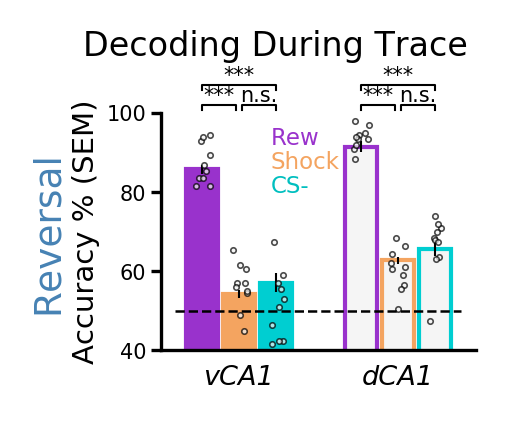

In [16]:
from matplotlib.patches import Patch
labels = ['vCA1','dCA1']
x = np.arange(len(labels))  # the label locations
width = 0.3# the width of the bars
loops=10
r={}
s={}
p={}
to_plot = [0,1]
fig, ax = pl.subplots(figsize=(1.7,1.3))

            
r[sess] = np.array(np.std(baseline_scores_tb_6_rw_vhpc['post_rev'][-loops:])*100/np.sqrt(loops-1))
ax.bar(-width/3-.25, np.mean(baseline_scores_tb_6_rw_vhpc['post_rev'][-loops:])*100, width, edgecolor='darkorchid',color='darkorchid',yerr=r[sess])
ax.scatter(-width/3-.25+np.random.random(loops)*width/2-width/4.5, baseline_scores_tb_6_rw_vhpc['post_rev'][:loops]*100, color='whitesmoke',
           s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
s[sess] = np.array(np.std(baseline_scores_tb_6_sh_vhpc['post_rev'][-loops:])*100/np.sqrt(loops-1))
ax.bar(0,  np.mean(baseline_scores_tb_6_sh_vhpc['post_rev'][-loops:])*100, width,edgecolor='sandybrown',color='sandybrown',yerr=s[sess])
ax.scatter(0+np.random.random(loops)*width/2-width/4.5, baseline_scores_tb_6_sh_vhpc['post_rev'][:loops]*100, color='whitesmoke',
           s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
p[sess] = np.array(np.std(baseline_scores_tb_6_csm_vhpc['post_rev'][-loops:])*100/np.sqrt(loops-1))
ax.bar(width/3+.25,  np.mean(baseline_scores_tb_6_csm_vhpc['post_rev'][-loops:])*100, width,edgecolor='darkturquoise',color='darkturquoise',yerr=p[sess])
ax.scatter(width/3+.25+np.random.random(loops)*width/2-width/4.5, baseline_scores_tb_6_csm_vhpc['post_rev'][:loops]*100, color='whitesmoke',
           s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
r[sess] = np.array(np.std(baseline_scores_tb_6_rw_dhpc['post_rev'][-loops:])*100/np.sqrt(loops-1))
ax.bar(1.5-width/3-.25, np.mean(baseline_scores_tb_6_rw_dhpc['post_rev'][-loops:])*100, width, edgecolor='darkorchid',color='whitesmoke',yerr=r[sess])
ax.scatter(1.5-width/3-.25+np.random.random(loops)*width/2-width/4.5, baseline_scores_tb_6_rw_dhpc['post_rev'][:loops]*100, color='whitesmoke',
           s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
s[sess] = np.array(np.std(baseline_scores_tb_6_sh_dhpc['post_rev'][-loops:])*100/np.sqrt(loops-1))
ax.bar(1.5,  np.mean(baseline_scores_tb_6_sh_dhpc['post_rev'][-loops:])*100, width,edgecolor='sandybrown',color='whitesmoke',yerr=s[sess])
ax.scatter(1.5+np.random.random(loops)*width/2-width/4.5, baseline_scores_tb_6_sh_dhpc['post_rev'][:loops]*100, color='whitesmoke',
           s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
p[sess] = np.array(np.std(baseline_scores_tb_6_csm_dhpc['post_rev'][-loops:])*100/np.sqrt(loops-1))
ax.bar(1.5+width/3+.25,  np.mean(baseline_scores_tb_6_csm_dhpc['post_rev'][-loops:])*100, width,edgecolor='darkturquoise',color='whitesmoke',yerr=p[sess])
ax.scatter(1.5+width/3+.25+np.random.random(loops)*width/2-width/4.5, baseline_scores_tb_6_csm_dhpc['post_rev'][:loops]*100, color='whitesmoke',
           s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')

ax.hlines(50,-.6,2.1, color='k', lw=.6, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy % (SEM)',labelpad=1.5)
#ax.set_title('Decoding During CS')
ax.set_ylim(40,100)
ax.set_xticks([0,1.5])
ax.set_xticklabels(labels,fontstyle='italic',fontsize=6.5)
#ax.legend([Patch(facecolor='darkorchid'),Patch(facecolor='sandybrown'),Patch(facecolor='darkturquoise')],
#          ['Rew','Shock','CS-'],loc=(.95,.6),frameon=False)
ax.text(.3,92,'Rew',color='darkorchid',fontsize=5.5)
ax.text(.3,86,'Shock',color='sandybrown',fontsize=5.5)
ax.text(.3,80,'CS-',color='c',fontsize=5.5)
ax.tick_params(axis='both',bottom=False,pad=1,length=2.5)
pvs=[]
for reg,i in zip(['vhpc','dhpc'], [0,1.5]):
    pvs.append(add_significance(ax,eval("baseline_scores_tb_6_rw_%s['post_rev'][-loops:]"%reg), eval("baseline_scores_tb_6_sh_%s['post_rev'][-loops:]"%reg),
        -width/3-.25+i,i-.03,102,mcc=2))
    pvs.append(add_significance(ax,eval("baseline_scores_tb_6_sh_%s['post_rev'][-loops:]"%reg), eval("baseline_scores_tb_6_csm_%s['post_rev'][-loops:]"%reg),
        i+.03,width/3+.25+i,102,mcc=2))
    pvs.append(add_significance(ax,eval("baseline_scores_tb_6_rw_%s['post_rev'][-loops:]"%reg), eval("baseline_scores_tb_6_csm_%s['post_rev'][-loops:]"%reg),
        -width/3-.25+i,width/3+.25+i,107,mcc=2))
    print reg,'rw/sh',report_stats(eval("baseline_scores_tb_6_rw_%s['post_rev'][-loops:]"%reg), eval("baseline_scores_tb_6_sh_%s['post_rev'][-loops:]"%reg),mcc=2)
    print reg,'rw/CS-',report_stats(eval("baseline_scores_tb_6_rw_%s['post_rev'][-loops:]"%reg), eval("baseline_scores_tb_6_csm_%s['post_rev'][-loops:]"%reg),mcc=2)
    print reg,'sh/CS-',report_stats(eval("baseline_scores_tb_6_sh_%s['post_rev'][-loops:]"%reg), eval("baseline_scores_tb_6_csm_%s['post_rev'][-loops:]"%reg),mcc=2)

pl.suptitle('Decoding During Trace',y=1.06,fontsize=8)
ax.text(-1.8,70,'Reversal',rotation=90,fontsize=9,color='steelblue',ha='center',va='center')
fig.tight_layout(pad=2.5)

fig.savefig('../figures/%s_bars_tr_RevLate.pdf'%NOTEBOOK_NAME)

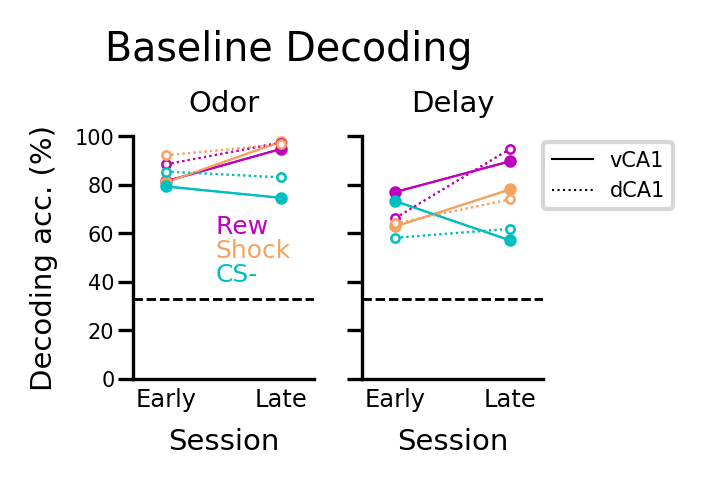

In [117]:
fig,ax = pl.subplots(1,2,figsize=(2,1.5),sharey=True)
v={}
d={}
loops=10
expectations = 'pre','post'

# Add connecting lines            
for ex,z in zip(expectations,(.4,1.1)):
    for tb,tb_la,x in zip((4,6),('Odor','Delay'),(range(2))):
        ax[x].plot([p for p in (.4,1.1)],[np.mean(eval("baseline_scores_tb_%s_rw_vhpc[ex][-loops:]"%tb))*100 for ex in expectations],color='m')
        ax[x].plot([p for p in (.4,1.1)],[np.mean(eval("baseline_scores_tb_%s_sh_vhpc[ex][-loops:]"%tb))*100 for ex in expectations],color='sandybrown')
        ax[x].plot([p for p in (.4,1.1)],[np.mean(eval("baseline_scores_tb_%s_csm_vhpc[ex][-loops:]"%tb))*100 for ex in expectations],color='c')
        ax[x].plot([p for p in (.4,1.1)],[np.mean(eval("baseline_scores_tb_%s_rw_dhpc[ex][-loops:]"%tb))*100 for ex in expectations],ls='dotted',color='m')
        ax[x].plot([p for p in (.4,1.1)],[np.mean(eval("baseline_scores_tb_%s_sh_dhpc[ex][-loops:]"%tb))*100 for ex in expectations],ls='dotted',color='sandybrown')
        ax[x].plot([p for p in (.4,1.1)],[np.mean(eval("baseline_scores_tb_%s_csm_dhpc[ex][-loops:]"%tb))*100 for ex in expectations],ls='dotted',color='c')
                        
            
for ex,z in zip(['pre','post'],(.4,1.1)):
    for tb,tb_la,x in zip((4,6),('Odor','Delay'),(range(2))):
            #v[ex] = np.array(np.std(3.*eval("heatmaps_%s_vhpc[tb][0][0]"%ex)/np.sum(eval("heatmaps_%s_vhpc[tb]"%ex)))*100/(np.sqrt(loops-1)))
            ax[x].plot(z, np.mean(eval("baseline_scores_tb_%s_rw_vhpc[ex][-loops:]"%tb))*100, 'o', color='m',markersize=2)
            #ax[x].errorbar(z, (np.mean(3.*eval("heatmaps_%s_vhpc[tb][0][0]"%ex)/np.sum(eval("heatmaps_%s_vhpc[tb]"%ex)))*100),yerr=v[ex],color='c')  
            ax[x].plot(z, np.mean(eval("baseline_scores_tb_%s_sh_vhpc[ex][-loops:]"%tb))*100, 'o', color='sandybrown',markersize=2)
            ax[x].plot(z, np.mean(eval("baseline_scores_tb_%s_csm_vhpc[ex][-loops:]"%tb))*100, 'o',color='c',markersize=2)
            ax[x].plot(z, np.mean(eval("baseline_scores_tb_%s_rw_dhpc[ex][-loops:]"%tb))*100, 'o', color='whitesmoke', mec='m',markersize=2,mew=.6)
            ax[x].plot(z, np.mean(eval("baseline_scores_tb_%s_sh_dhpc[ex][-loops:]"%tb))*100, 'o', color='whitesmoke', mec='sandybrown',markersize=2,mew=.6)
            ax[x].plot(z, np.mean(eval("baseline_scores_tb_%s_csm_dhpc[ex][-loops:]"%tb))*100, 'o',color='whitesmoke', mec='c',markersize=2,mew=.6,label='dCA1')

        
            ax[x].tick_params(axis='x',bottom=False,pad=-1.5) # labels along the bottom edge are off
            ax[x].tick_params(axis='y',pad=1) # labels along the bottom edge are off
            ax[0].set_ylabel('Decoding acc. (%)')
            ax[x].set_ylim(0,100)
            ax[x].hlines(33, 0.2,1.3, color='k', lw=.6, linestyles='dashed')
            ax[x].set_title(tb_la,y=1)
            ax[x].set_xlim(0.2,1.3)
            ax[x].set_xticks((.4,1.1))
            ax[x].set_xticklabels(['Early','Late'],fontsize=5.8)
            ax[x].set_xlabel("Session")
            
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], label='vCA1',color='k'),
                   Line2D([0], [0], ls='dotted', label='dCA1',color='k')]

ax[1].legend(handles=legend_elements,loc=(1,.7))

ax[0].text(.7,60,'Rew',color='m',fontsize=6.)
ax[0].text(.7,50,'Shock',color='sandybrown',fontsize=6.)
ax[0].text(.7,40,'CS-',color='c',fontsize=6.)

fig.suptitle('Baseline Decoding',fontsize=9.5,y=1.04)
fig.tight_layout(pad=2)

fig.savefig('../figures/%s_lines_dv.pdf'%NOTEBOOK_NAME)

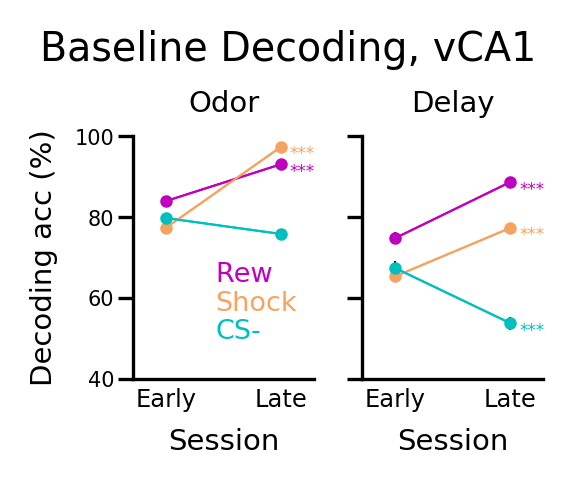

In [206]:
fig,ax = pl.subplots(1,2,figsize=(2,1.5),sharey=True)
v={}
d={}
loops=10
expectations = 'pre','post'

# Add connecting lines            
for ex,z in zip(expectations,(.4,1.1)):
    for tb,tb_la,x in zip((4,6),('Odor','Delay'),(range(2))):
        ax[x].plot([p for p in (.4,1.1)],[np.mean(eval("baseline_scores_tb_%s_rw_vhpc[ex][:loops]"%tb))*100 for ex in expectations],color='m')
        ax[x].plot([p for p in (.4,1.1)],[np.mean(eval("baseline_scores_tb_%s_sh_vhpc[ex][:loops]"%tb))*100 for ex in expectations],color='sandybrown')
        ax[x].plot([p for p in (.4,1.1)],[np.mean(eval("baseline_scores_tb_%s_csm_vhpc[ex][:loops]"%tb))*100 for ex in expectations],color='c')
            
for ex,z in zip(['pre','post'],(.4,1.1)):
    for tb,tb_la,x in zip((4,6),('Odor','Delay'),(range(2))):
        for comp,c in zip (['rw','sh','csm'],['m','sandybrown','c']):
            v[ex] = np.std(eval("baseline_scores_tb_%s_%s_vhpc[ex][:loops]"%(tb,comp)))*100/np.sqrt(loops)
            ax[x].plot(z, np.mean(eval("baseline_scores_tb_%s_%s_vhpc[ex][:loops]"%(tb,comp)))*100, 'o', color=c,markersize=2)
            ax[x].errorbar(z, np.mean(eval("baseline_scores_tb_%s_%s_vhpc[ex][:loops]"%(tb,comp)))*100,yerr=v[ex],color='k')  

        
            ax[x].tick_params(axis='x',bottom=False,pad=-1.5) # labels along the bottom edge are off
            ax[x].tick_params(axis='y',pad=1) # labels along the bottom edge are off
            ax[0].set_ylabel('Decoding acc (%)')
            ax[x].set_ylim(40,100)
            #ax[x].hlines(33, 0.2,1.3, color='k', lw=.6, linestyles='dashed')
            ax[x].set_title(tb_la,y=1)
            ax[x].set_xlim(0.2,1.3)
            ax[x].set_xticks((.4,1.1))
            ax[x].set_xticklabels(['Early','Late'],fontsize=5.8)
            ax[x].set_xlabel("Session")
            
from matplotlib.lines import Line2D

pvs=[]
for x,t in zip([0,1],[4,6]):
        pvs.append(add_significance_point(ax[x],eval("baseline_scores_tb_%s_rw_vhpc['pre'][:loops]"%(t)),
           eval("baseline_scores_tb_%s_rw_vhpc['post'][:loops]"%(t)),
           1.23,np.mean(eval("baseline_scores_tb_%s_rw_vhpc['post'][:loops]"%(t)))*100-3,color='m'))
        pvs.append(add_significance_point(ax[x],eval("baseline_scores_tb_%s_sh_vhpc['pre'][:loops]"%(t)),
           eval("baseline_scores_tb_%s_sh_vhpc['post'][:loops]"%(t)),
           1.23,np.mean(eval("baseline_scores_tb_%s_sh_vhpc['post'][:loops]"%(t)))*100-3,color='sandybrown'))
        pvs.append(add_significance_point(ax[x],eval("baseline_scores_tb_%s_csm_vhpc['pre'][:loops]"%(t)),
           eval("baseline_scores_tb_%s_csm_vhpc['post'][:loops]"%(t)),
           1.23,np.mean(eval("baseline_scores_tb_%s_csm_vhpc['post'][:loops]"%(t)))*100-3,color='c'))
        
ax[0].text(.7,64,'Rew',color='m',fontsize=6.5)
ax[0].text(.7,57,'Shock',color='sandybrown',fontsize=6.5)
ax[0].text(.7,50,'CS-',color='c',fontsize=6.5)

fig.suptitle('Baseline Decoding, vCA1',fontsize=9.5,y=1.04)
fig.tight_layout(pad=2)

fig.savefig('../figures/%s_lines_v.pdf'%NOTEBOOK_NAME)

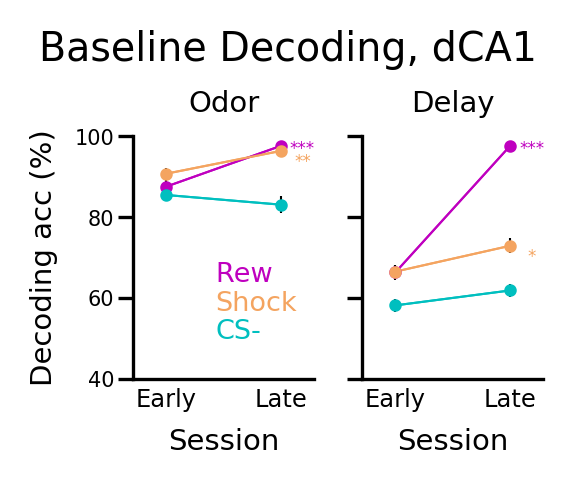

In [205]:
fig,ax = pl.subplots(1,2,figsize=(2,1.5),sharey=True)
v={}
d={}
loops=10
expectations = 'pre','post'

# Add connecting lines            
for ex,z in zip(expectations,(.4,1.1)):
    for tb,tb_la,x in zip((4,6),('Odor','Delay'),(range(2))):
        ax[x].plot([p for p in (.4,1.1)],[np.mean(eval("baseline_scores_tb_%s_rw_dhpc[ex][:loops]"%tb))*100 for ex in expectations],color='m')
        ax[x].plot([p for p in (.4,1.1)],[np.mean(eval("baseline_scores_tb_%s_sh_dhpc[ex][:loops]"%tb))*100 for ex in expectations],color='sandybrown')
        ax[x].plot([p for p in (.4,1.1)],[np.mean(eval("baseline_scores_tb_%s_csm_dhpc[ex][:loops]"%tb))*100 for ex in expectations],color='c')
            
for ex,z in zip(['pre','post'],(.4,1.1)):
    for tb,tb_la,x in zip((4,6),('Odor','Delay'),(range(2))):
        for comp,c in zip (['rw','sh','csm'],['m','sandybrown','c']):
            v[ex] = np.std(eval("baseline_scores_tb_%s_%s_dhpc[ex][:loops]"%(tb,comp)))*100/np.sqrt(loops)
            ax[x].plot(z, np.mean(eval("baseline_scores_tb_%s_%s_dhpc[ex][:loops]"%(tb,comp)))*100, 'o', color=c,markersize=2)
            ax[x].errorbar(z, np.mean(eval("baseline_scores_tb_%s_%s_dhpc[ex][:loops]"%(tb,comp)))*100,yerr=v[ex],color='k')  

        
            ax[x].tick_params(axis='x',bottom=False,pad=-1.5) # labels along the bottom edge are off
            ax[x].tick_params(axis='y',pad=1) # labels along the bottom edge are off
            ax[0].set_ylabel('Decoding acc (%)')
            ax[x].set_ylim(40,100)
            #ax[x].hlines(33, 0.2,1.3, color='k', lw=.6, linestyles='dashed')
            ax[x].set_title(tb_la,y=1)
            ax[x].set_xlim(0.2,1.3)
            ax[x].set_xticks((.4,1.1))
            ax[x].set_xticklabels(['Early','Late'],fontsize=5.8)
            ax[x].set_xlabel("Session")
            
from matplotlib.lines import Line2D

pvs=[]
for x,t in zip([0,1],[4,6]):
        pvs.append(add_significance_point(ax[x],eval("baseline_scores_tb_%s_rw_dhpc['pre'][:loops]"%(t)),
           eval("baseline_scores_tb_%s_rw_dhpc['post'][:loops]"%(t)),
           1.23,np.mean(eval("baseline_scores_tb_%s_rw_dhpc['post'][:loops]"%(t)))*100-2,color='m'))
        pvs.append(add_significance_point(ax[x],eval("baseline_scores_tb_%s_sh_dhpc['pre'][:loops]"%(t)),
           eval("baseline_scores_tb_%s_sh_dhpc['post'][:loops]"%(t)),
           1.23,np.mean(eval("baseline_scores_tb_%s_sh_dhpc['post'][:loops]"%(t)))*100-4,color='sandybrown'))
        pvs.append(add_significance_point(ax[x],eval("baseline_scores_tb_%s_csm_dhpc['pre'][:loops]"%(t)),
           eval("baseline_scores_tb_%s_csm_dhpc['post'][:loops]"%(t)),
           1.23,np.mean(eval("baseline_scores_tb_%s_csm_dhpc['post'][:loops]"%(t)))*100-3,color='c'))
        
ax[0].text(.7,64,'Rew',color='m',fontsize=6.5)
ax[0].text(.7,57,'Shock',color='sandybrown',fontsize=6.5)
ax[0].text(.7,50,'CS-',color='c',fontsize=6.5)

fig.suptitle('Baseline Decoding, dCA1',fontsize=9.5,y=1.04)
fig.tight_layout(pad=2)

fig.savefig('../figures/%s_lines_d.pdf'%NOTEBOOK_NAME)

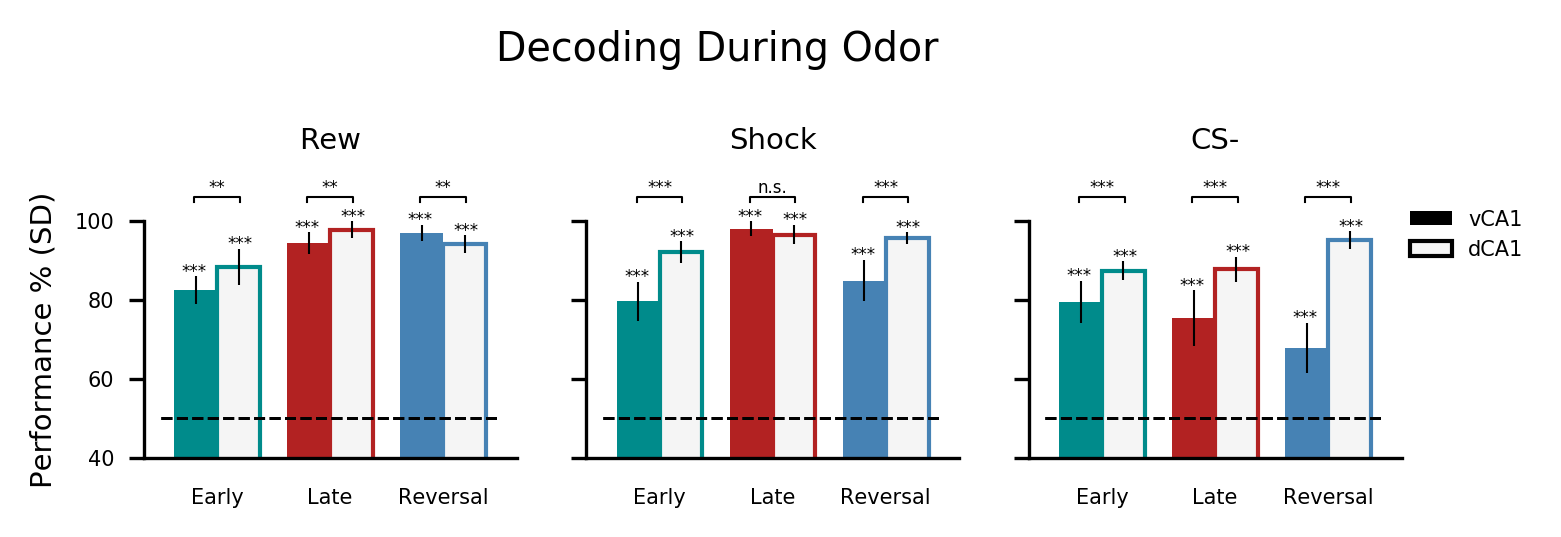

In [35]:
from matplotlib.patches import Patch
labels = 'Early','Late','Reversal'
x = np.arange(len(labels))  # the label locations
width = 0.38  # the width of the bars
loops = 15
v={}
d={}
pvs=[]
expectations = 'pre','post','post_rev'

fig, ax = pl.subplots(1,3,figsize=(5,1.8),sharey=True)
for lab, l in zip(['rw','sh','csm'],range(3)):
    for ex,c,i in zip(expectations,dark_co,range(len(expectations))):
        v[sess] = np.array(np.std(eval("baseline_scores_tb_4_%s_vhpc[ex][-loops:]"%lab))*100)
        ax[l].bar(i - width/2, np.mean(eval("baseline_scores_tb_4_%s_vhpc[ex][-loops:]"%lab))*100, width, color=c,yerr=v[sess])
        d[sess] = np.array(np.std(eval("baseline_scores_tb_4_%s_dhpc[ex][-loops:]"%lab))*100)
        ax[l].bar(i + width/2,  np.mean(eval("baseline_scores_tb_4_%s_dhpc[ex][-loops:]"%lab))*100, width,color='whitesmoke', edgecolor=c,yerr=d[sess])
        ax[l].hlines(50,-.5,2.5, color='k', lw=.7, linestyles='dashed')
        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax[0].set_ylabel('Performance % (SD)')
        #ax.set_title('Decoding During CS')
        ax[l].set_xticks(x)
        ax[l].set_xticklabels(labels)
        ax[2].legend([Patch(facecolor='k'),Patch(facecolor='whitesmoke',edgecolor='k')],['vCA1','dCA1'],loc=(1,.8),frameon=False)
        ax[l].tick_params(axis='x',bottom=False)
        ax[l].set_ylim(40,100)
        ax[l].set_title(comp_labels[l],y=1.2)

        pvs.append(add_significance(ax[l],eval("baseline_scores_tb_4_%s_vhpc[ex][-loops:]"%lab),eval("baseline_scores_tb_4_%s_dhpc[ex][-loops:]"%lab),
            -.2+i,0.2+i,106))
        pvs.append(sig_vs_chance(ax[l],eval("baseline_scores_tb_4_%s_vhpc[ex][-loops:]"%lab),.5,-.2+i,
                   np.mean(eval("baseline_scores_tb_4_%s_vhpc[ex][-loops:]"%lab))*100+v[sess],loops=loops,sig_func=None,colors='k'))
        pvs.append(sig_vs_chance(ax[l],eval("baseline_scores_tb_4_%s_dhpc[ex][-loops:]"%lab),.5, .2+i,
                   np.mean(eval("baseline_scores_tb_4_%s_dhpc[ex][-loops:]"%lab))*100+d[sess],loops=loops,sig_func=None,colors='k'))
pl.suptitle('Decoding During Odor',y=1,fontsize=9.5)
fig.tight_layout(pad=3)

#fig.savefig('../img/%s_gmin_bars_CS.jpg'%NOTEBOOK_NAME)

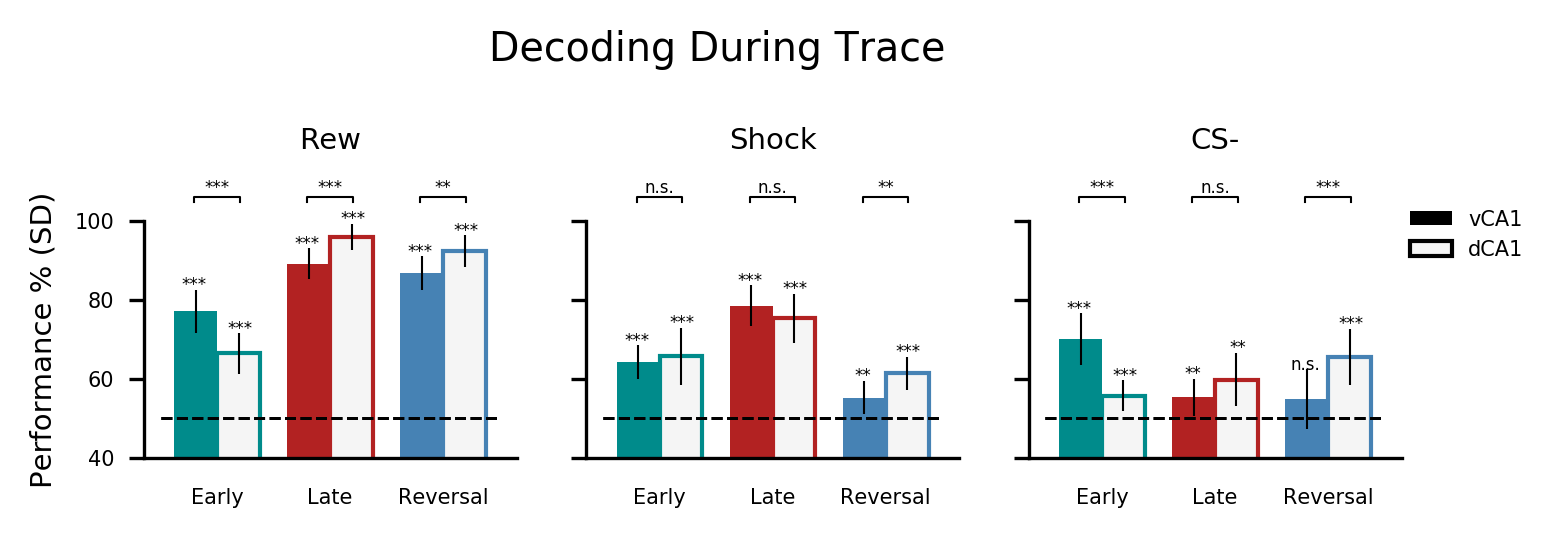

In [36]:
from matplotlib.patches import Patch
labels = 'Early','Late','Reversal'
x = np.arange(len(labels))  # the label locations
width = 0.38  # the width of the bars
loops = 15
v={}
d={}
pvs=[]
expectations = 'pre','post','post_rev'

fig, ax = pl.subplots(1,3,figsize=(5,1.8),sharey=True)
for lab, l in zip(['rw','sh','csm'],range(3)):
    for ex,c,i in zip(expectations,dark_co,range(len(expectations))):
        v[sess] = np.array(np.std(eval("baseline_scores_tb_6_%s_vhpc[ex][-loops:]"%lab))*100)
        ax[l].bar(i - width/2, np.mean(eval("baseline_scores_tb_6_%s_vhpc[ex][-loops:]"%lab))*100, width, color=c,yerr=v[sess])
        d[sess] = np.array(np.std(eval("baseline_scores_tb_6_%s_dhpc[ex][-loops:]"%lab))*100)
        ax[l].bar(i + width/2,  np.mean(eval("baseline_scores_tb_6_%s_dhpc[ex][-loops:]"%lab))*100, width,color='whitesmoke', edgecolor=c,yerr=d[sess])
        ax[l].hlines(50,-.5,2.5, color='k', lw=.7, linestyles='dashed')
        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax[0].set_ylabel('Performance % (SD)')
        #ax.set_title('Decoding During CS')
        ax[l].set_xticks(x)
        ax[l].set_xticklabels(labels)
        ax[2].legend([Patch(facecolor='k'),Patch(facecolor='whitesmoke',edgecolor='k')],['vCA1','dCA1'],loc=(1,.8),frameon=False)
        ax[l].tick_params(axis='x',bottom=False)
        ax[l].set_ylim(40,100)
        ax[l].set_title(comp_labels[l],y=1.2)

        pvs.append(add_significance(ax[l],eval("baseline_scores_tb_6_%s_vhpc[ex][-loops:]"%lab),eval("baseline_scores_tb_6_%s_dhpc[ex][-loops:]"%lab),
            -.2+i,0.2+i,106))
        pvs.append(sig_vs_chance(ax[l],eval("baseline_scores_tb_6_%s_vhpc[ex][-loops:]"%lab),.5,-.2+i,
                   np.mean(eval("baseline_scores_tb_6_%s_vhpc[ex][-loops:]"%lab))*100+v[sess],loops=loops,sig_func=None,colors='k'))
        pvs.append(sig_vs_chance(ax[l],eval("baseline_scores_tb_6_%s_dhpc[ex][-loops:]"%lab),.5, .2+i,
                   np.mean(eval("baseline_scores_tb_6_%s_dhpc[ex][-loops:]"%lab))*100+d[sess],loops=loops,sig_func=None,colors='k'))
pl.suptitle('Decoding During Trace',y=1,fontsize=9.5)
fig.tight_layout(pad=3)

#fig.savefig('../img/%s_gmin_bars_CS.jpg'%NOTEBOOK_NAME)

/home/fabios/anaconda2/lib/python2.7/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs [u'ls', u'linestyle'] which are all aliases for u'linestyle'.  Kept value from u'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))


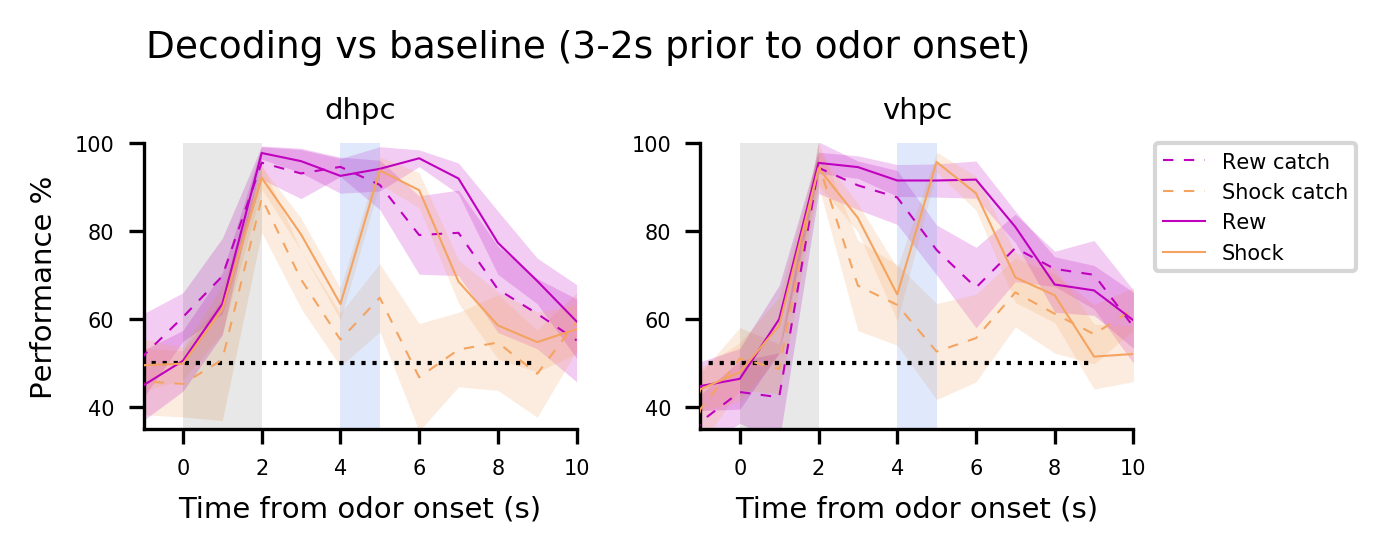

In [37]:
fig, ax = pl.subplots(1,2, figsize=(4, 1.7))

loops=10
for comp,c,la,line in zip(['rwnd','shnd','rw','sh'],['m','sandybrown','m','sandybrown'],['Rew catch','Shock catch','Rew','Shock'],
                          [(0,(5,5)),(0,(5,5)),'-','-']):
    for y in [1]:
        for x,reg in zip (range(2),['dhpc','vhpc']):
            ax[x].plot([(t-2) for t in range(13)], [(np.mean(eval("baseline_scores_tb_%s_%s_%s['catch'][-loops:]"%(t,comp,reg)))*100) for t in range(13)],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la,linestyle=line)
            m = np.array([(np.mean(eval("baseline_scores_tb_%s_%s_%s['catch'][-loops:]"%(t,comp,reg)))*100) for t in range(13)])
            s = np.array([np.std(eval("baseline_scores_tb_%s_%s_%s['catch'][-loops:]"%(t,comp,reg)))*100 for t in range(13)])
            ax[x].fill_between([(t-2) for t in range(13)],m-s,m+s,alpha=0.2,color=c,linewidth=0)

for x,reg in zip (range(2),['dhpc','vhpc']):
        ax[x].set_ylim(35, 100)
        ax[x].set_xlim(-1, 9)
        ax[x].set_xticks(np.arange(0,11, 2))
        ax[x].set_xticklabels(np.arange(0,11, 2))
        ax[x].hlines(50, -5,9, color='k', lw=1, linestyles='dotted')
        ax[x].set_xlabel('Time from odor onset (s)')
        ax[0].set_ylabel('Performance %')
        pt.plot_period_bar(ax[x], 0, start_end=(0, 2), color='k', delta_y=100,alpha=.09)
        pt.plot_period_bar(ax[x], 0, start_end=(4, 5), color='cornflowerblue', delta_y=100, alpha=.2)
        ax[x].set_title(reg)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs baseline (3-2s prior to odor onset)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

fig.savefig('../figures/%s_catch_dv.pdf'%NOTEBOOK_NAME)

In [41]:
save_workspace(db)

Could not store variable 'IPython'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'np'. Skipping...
